As a preface, I will define here some functions that will be useful later on in the analysis.

In [1]:
## Functions used in Time Series Project -- Lake Erie Water Levelss
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

sse<-function(pred, data){
  true<-as.vector(data)
  sum((pred-true)^2)
}

colors2<-col_vector
addplot<-function(pred,range=1:length(lkerie),color1){
  lines(x=c(time(lkerie))[range],y=c(lkerietrain,pred)[range],col=color1,lty="dashed")
}

get.best.arima <- function(x_ts, maxord = c(1,1,1,1,1,1))
{
  best.aic <- 1e8
  n <- length(x_ts)
  for (p in 0:maxord[1]) for(d in 0:maxord[2]) for(q in 0:maxord[3])
    for (P in 0:maxord[4]) for(D in 0:maxord[5]) for(Q in 0:maxord[6])
    {
      fit <- arima(x_ts, order = c(p,d,q),
                   seas = list(order = c(P,D,Q),
                               frequency(x_ts)), method = "CSS")
      fit.aic <- -2 * fit$loglik + (log(n) + 1) * length(fit$coef)
      if (fit.aic < best.aic)
      {
        best.aic <- fit.aic
        best.fit <- fit
        best.model <- c(p,d,q,P,D,Q)
      }
    }
  list(best.aic, best.fit, best.model)
}

In [2]:
library(forecast)
library(prophet)
library(tidyr)
library(TSA)
library(lubridate)

Loading required package: Rcpp
Loading required package: rlang

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



The dataset I have chosen is a monthly recording of water levels in Lake Erie from the period between 1921 and 1970. The dataset is available at the following link: https://datamarket.com/data/set/22pw/monthly-lake-erie-levels-1921-1970#!ds=22pw&display=line&numberformat=n1.  Below is a plot of the time series over time:

# Importing the data


In [4]:
#lkerie<-dmseries("https://datamarket.com/data/set/22pw/monthly-lake-erie-levels-1921-1970#!ds=22pw&display=line")
#lkerie <- as.ts(lkerie,frequency=12)

#Note: update as of 2019, datamarket is no longer availiable. As an alternative, I am using data from a different source
# that has the lake erie water levels as well. 

lkerie = read.csv('http://lre-wm.usace.army.mil/ForecastData/GLHYD_data_english.csv', skip=12)
mask = (lkerie$year <= 1970) & (lkerie$year >= 1921)
lkerie = lkerie[mask, 'Erie']
lkerie <- ts(lkerie,frequency=12, start=c(1921, 1))

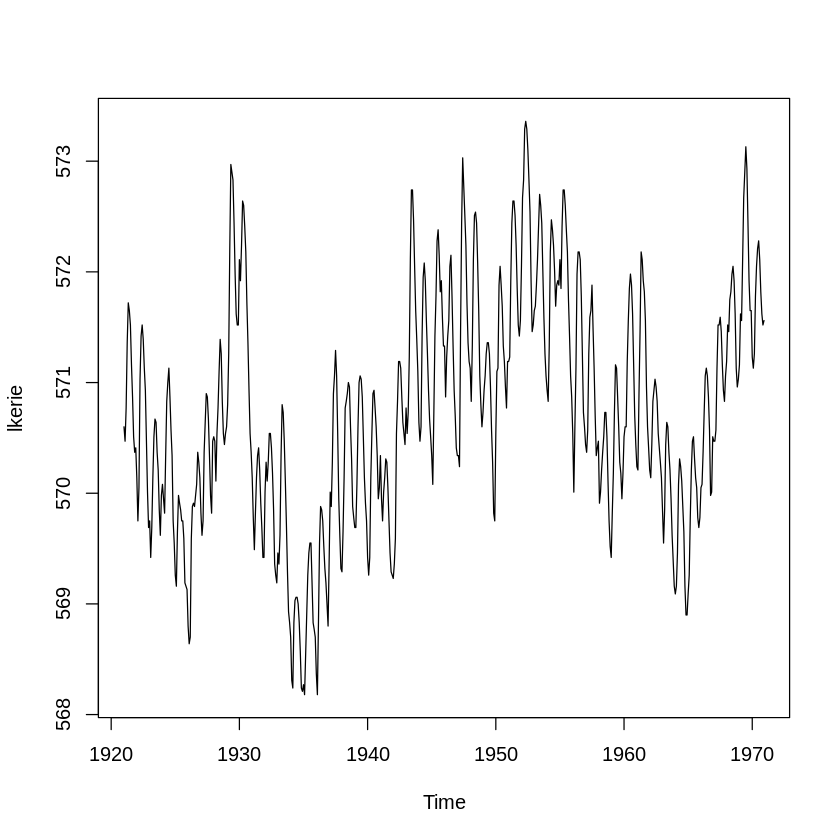

In [5]:
plot(lkerie)

We can see that the water levels seem to jump somewhat cyclically over time. This is typical of physical processes, and thus it is an interesting dataset to analyze. We see that over time the water levels decreased initially, and then began to increase again somewhat steadily from the 1940s onwards. While there is clearly a seasonal component at work here, it is not so clear how this seasonal component operates initially from the plot above.

I first begin by fitting a seasonal means with linear trend model to summarize and get an idea of the seasonal component of the data. I then built four models – the Holt Winters model, an SARIMA model, a model decomposing the seasonal component with spectral analysis, and a model from the prophet package. I then compare the models using the sum squared errors and plotting them against the true data values.

I have separated the time series into two sets, as shown below. These are the training and test sets I will be using to evaluate how effective each of the models I fit are at estimating the true time series. The following code initializes the dataset as a time series, and creates a training and test dataset to perform analysis on. The test set is the last 12 observations, or one year, of the time series.




In [6]:

lkerietrain<-ts(lkerie[1:(length(lkerie)-12)], frequency=12)
lkerietest<-lkerie[(length(lkerie)-11):length(lkerie)]
tail(lkerietrain)


[1] 600

      Jul    Aug    Sep    Oct    Nov    Dec
49 573.13 572.93 572.44 571.92 571.65 571.65

After this initialization, the dataset is in good condition and doesn’t need to be cleaned any further. The first 6 values of the time series are shown below:

# Seasonal Means Model
The first model I fit was a seasonal means model, to get a sense of the seasonality of the dataset. Although this is a simplistic model that will not be used to model the data itself, it provides good insight into the seasonal nature of the time series. Below is a plot of the time series with the months added to the plot:



In [7]:
season_<-season(lkerie)
time_<-time(lkerie)

We can see that the time series tends to peak around the summer time, and has troughs in the colder months. The seasonal means model gives us more insight into how this is occurring:


In [8]:
help(plot)


Call:
lm(formula = lkerie ~ season_ + time_)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0887 -0.6366 -0.0174  0.6178  2.3333 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      526.266512   4.902892 107.338  < 2e-16 ***
season_February   -0.045883   0.178105  -0.258 0.796791    
season_March       0.177633   0.178105   0.997 0.319006    
season_April       0.725750   0.178106   4.075 5.24e-05 ***
season_May         1.055267   0.178107   5.925 5.33e-09 ***
season_June        1.165384   0.178108   6.543 1.31e-10 ***
season_July        1.125900   0.178109   6.321 5.13e-10 ***
season_August      0.918617   0.178111   5.158 3.43e-07 ***
season_September   0.612734   0.178113   3.440 0.000623 ***
season_October     0.274650   0.178115   1.542 0.123616    
season_November    0.024167   0.178117   0.136 0.892120    
season_December   -0.017116   0.178120  -0.096 0.923479    
time_              0.022599   0.002519   8.971  < 2e-16 ***
---
S

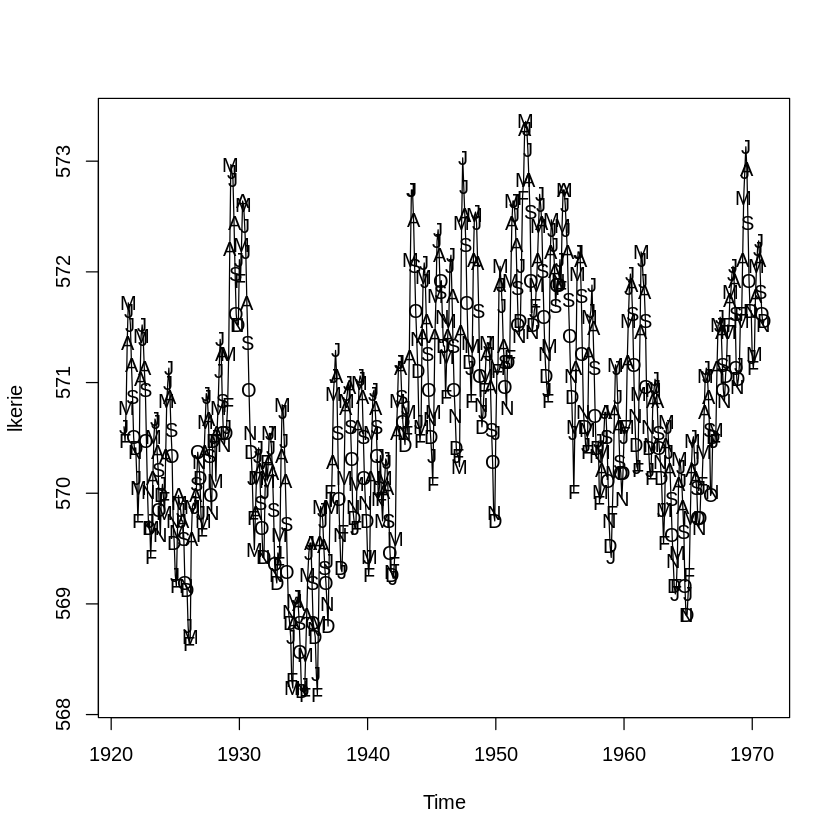

In [9]:
seasonmean<-lm(lkerie~season_+time_)

summary(seasonmean)

plot(lkerie)
points(y=lkerie,x=time(lkerie),pch=as.vector(season(lkerie)))

Indeed, we can see that the seasonal means model has quite a bit of significant components, suggesting that there is a good amount of seasonality in the data. However, this is not consistent, with some months having insignificant values. In general, we can see that the summer months have positive coefficients, while the colder months (which are not nearly as significant) sit somewhere close to zero. This agrees with the earlier findings from the time series plot.

Next, I perform a decomposition of the time series, to see how this package can break up the time series into seasonal, trend and random components.



[1] -0.5042163 -0.5479152 -0.3256533  0.2217786  0.5506732  0.6644317
 [7]  0.6272718  0.4200524  0.1147888 -0.2249646 -0.4772350 -0.5190122

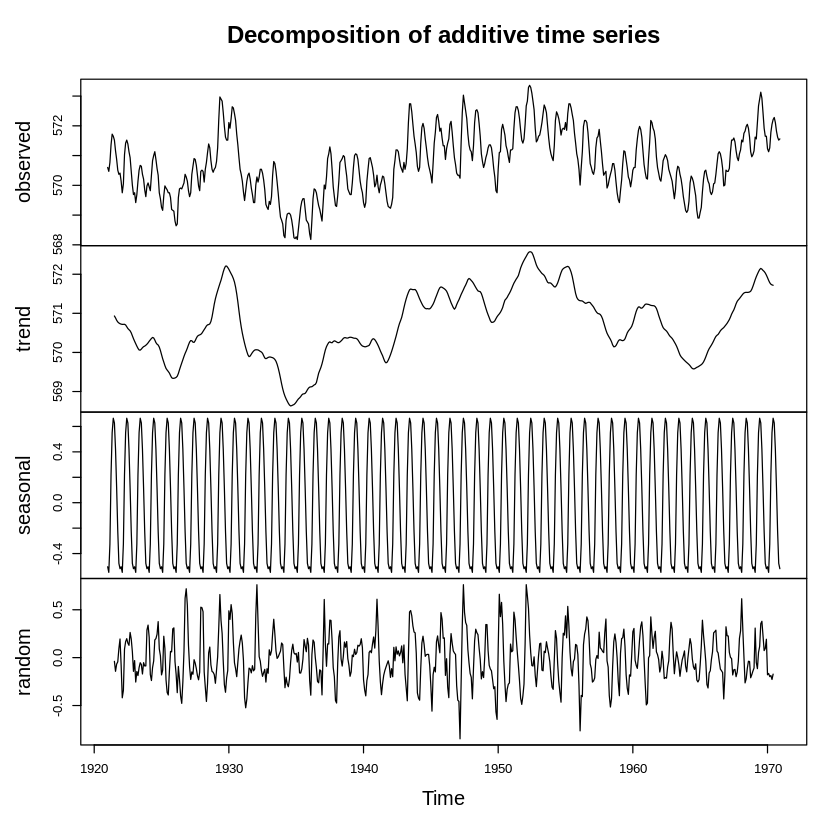

In [10]:
madecomp<-decompose(lkerie)
plot(madecomp)
madecomp$seasonal[1:12]

We can see again that there is clearly a seasonal component to the time series. We can also see the general trend of decreasing and increasing. When these components are removed, we see a relatively stationary random process. This cyclical nature of the seasonality lead me to consider spectral analysis. However, first we will look at two other models which can deal with seasonality – the Holt Winters’ Model and a seasonal ARIMA model.

# Holt Winters' Model

I use two Holt-Winters’ Models (an additive and multiplicative model) to model the data. Below, I fit the two models, and plot the resulting fits. The Holt-Winters models both consider seasonal components, although the multiplicative model and additive model come up with different quantities for the coefficients (see the appendix for the summaries). However, the smoothing parameters are relatively the same in character, with alpha=0.8973698 beta=0.003048736 and gamma: 1. This indicates that the level and seasonality are smoothing based on observations in the distant past (with gamma = 1 meaning it is considering only the previous observations), while a small beta indicates that it is using the trend of only the nearest values. I have plotted one of the models below, but the other is very similar in nature. However, as we will see later, the prediction error is quite high – (and the prediction error for the multiplicative model is, predictably, much higher).


Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = lkerietrain)

Smoothing parameters:
 alpha: 0.8987307
 beta : 0.002926917
 gamma: 1

Coefficients:
             [,1]
a    5.720476e+02
b   -1.549754e-04
s1  -4.205078e-01
s2  -3.699342e-01
s3  -2.099025e-01
s4   3.027650e-01
s5   5.968531e-01
s6   6.435499e-01
s7   6.181102e-01
s8   4.454104e-01
s9   1.618096e-01
s10 -2.064551e-01
s11 -3.922436e-01
s12 -3.976096e-01

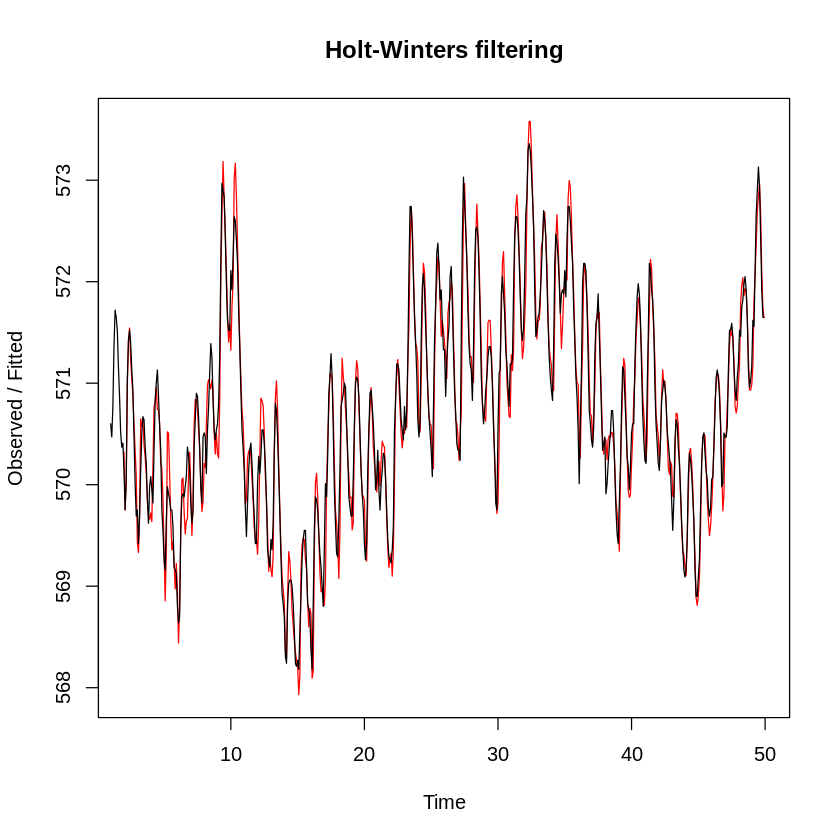

In [11]:
hw1<-HoltWinters(lkerietrain)
hw1
plot(hw1)

Holt-Winters exponential smoothing with trend and multiplicative seasonal component.

Call:
HoltWinters(x = lkerietrain, beta = NULL, seasonal = "multiplicative")

Smoothing parameters:
 alpha: 0.8986116
 beta : 0.002922608
 gamma: 1

Coefficients:
             [,1]
a    5.720483e+02
b   -1.676177e-04
s1   9.992631e-01
s2   9.993512e-01
s3   9.996315e-01
s4   1.000530e+00
s5   1.001045e+00
s6   1.001127e+00
s7   1.001082e+00
s8   1.000780e+00
s9   1.000284e+00
s10  9.996387e-01
s11  9.993134e-01
s12  9.993037e-01

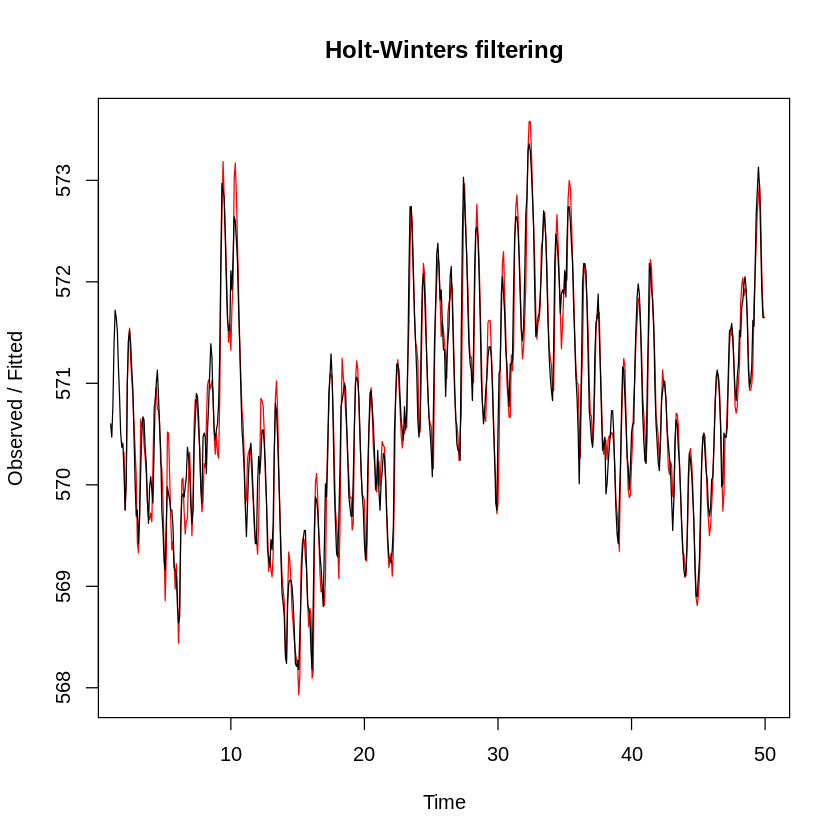

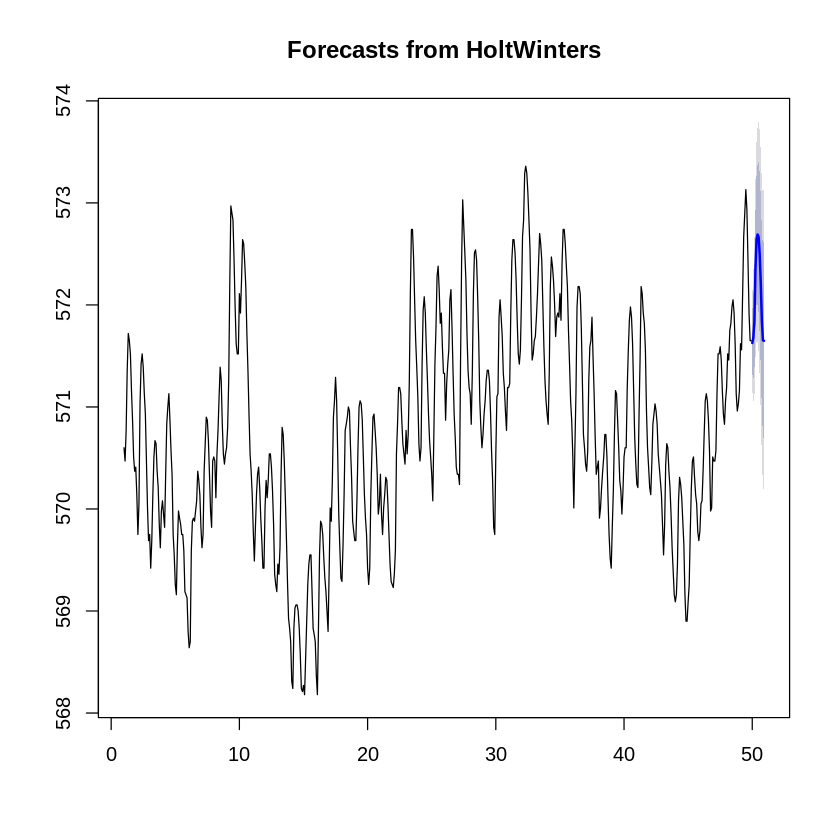

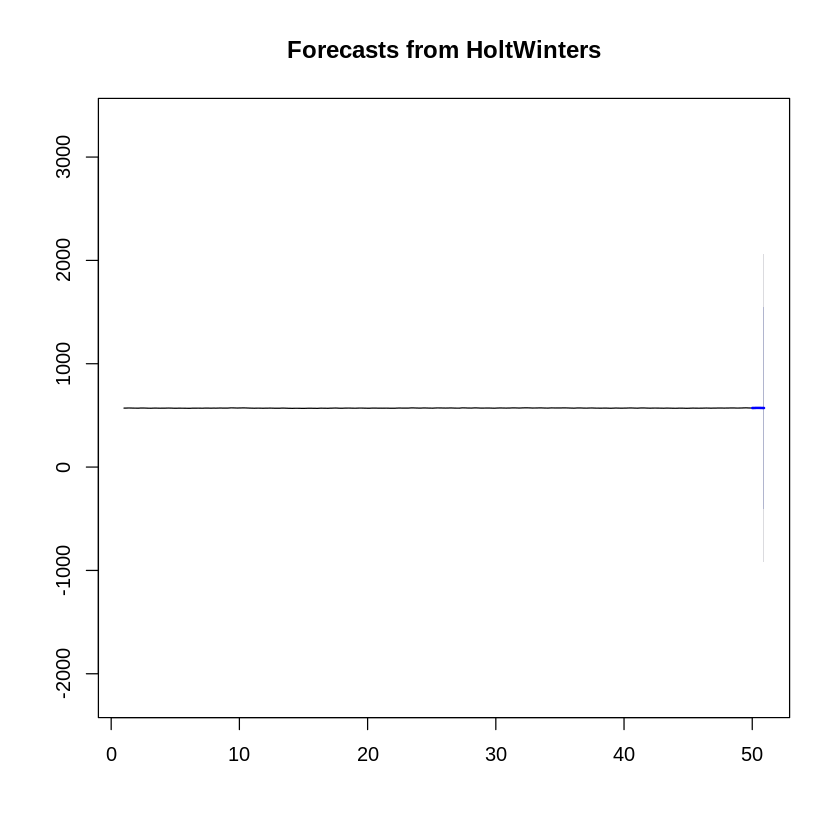

In [12]:

hw2<-HoltWinters(lkerietrain,beta=NULL,seasonal="multiplicative")
hw2
plot(hw2)

hw1pred<-predict(hw1,n.ahead=12,prediction.interval=TRUE)
hw2pred<-predict(hw2,n.ahead=12,prediction.interval=TRUE)

plot(forecast(hw1,12))
plot(forecast(hw2,12))

ssehw1<-sse(hw1pred[,1], lkerietest)
ssehw2<-sse(hw2pred[,1], lkerietest)


# SARIMA Modeling

Next, we will turn to using an ARIMA (or in this case, a seasonal ARIMA model) to model and predict the data. The above time series is not stationary, so we must transform it. The transformation which creates an optimal situation for ARIMA modeling is one that is roughly stationary. After looking through various transformations (including logarithmic, differencing and BoxCox transformations), I settled upon a differencing of logs. By differencing the logarithms of the model, we get a result that is very close to stationary. The resulting plot is plotted below.


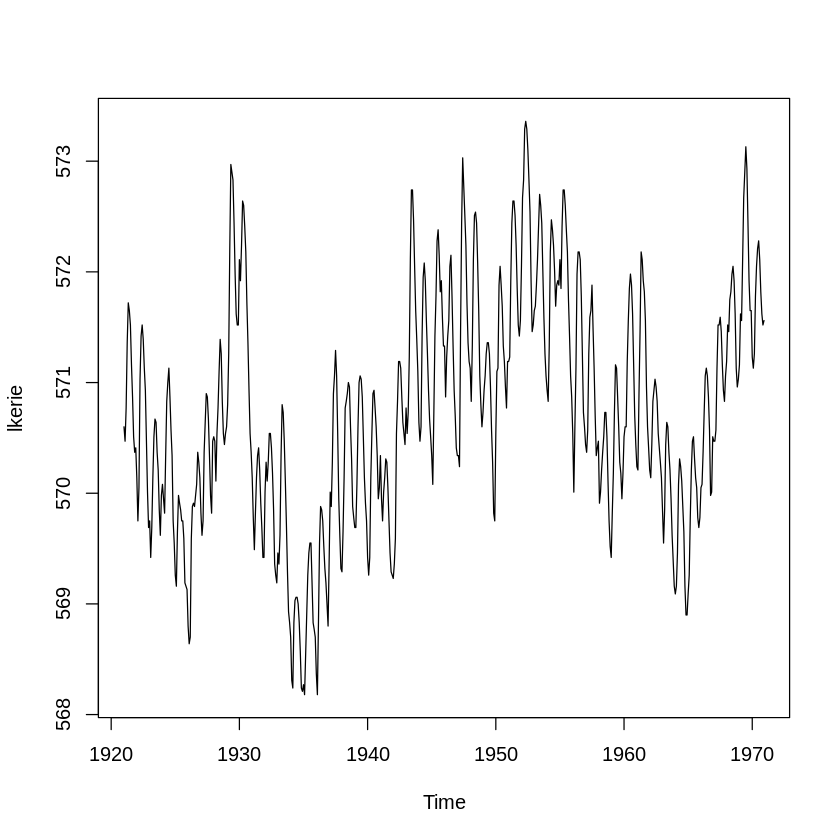

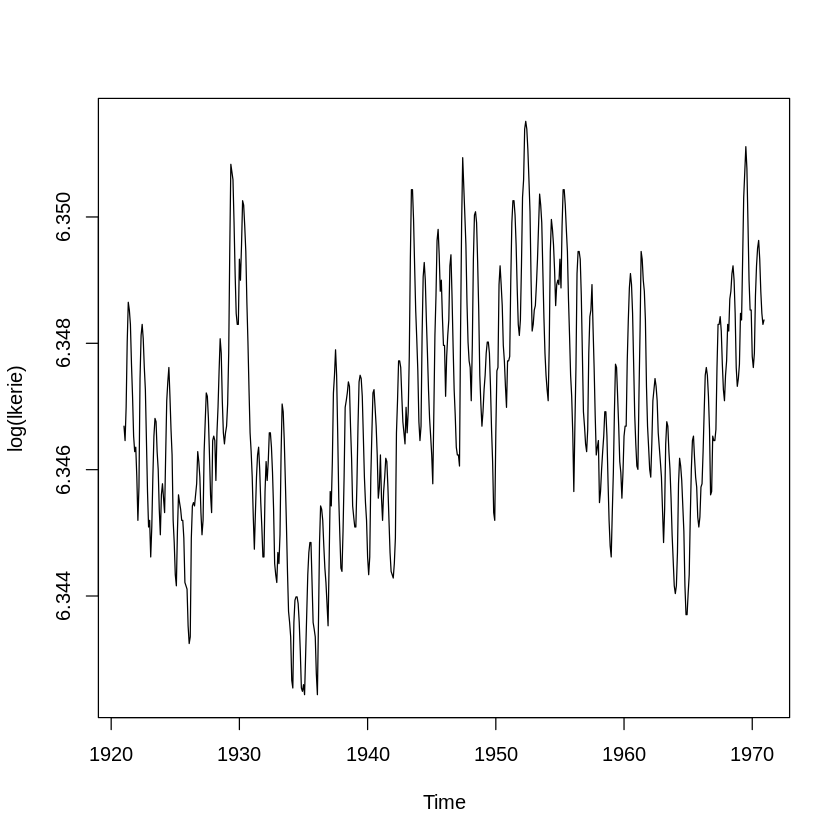

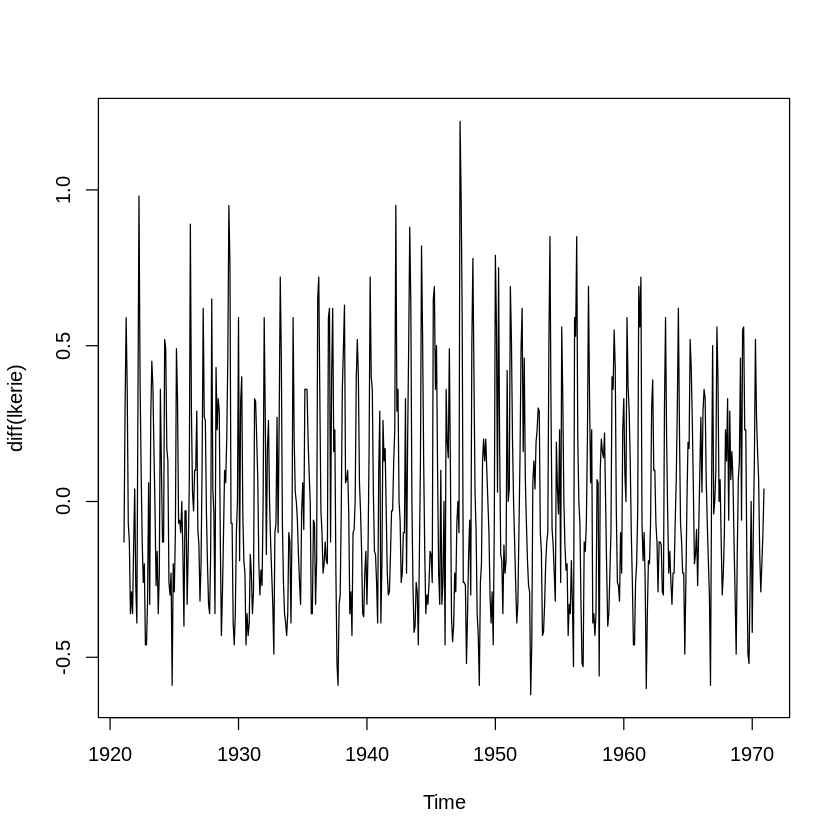

Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave code = 1”Warning message in arima0(x, order = c(i, 0L, 0L), include.mean = demean):
“possible convergence problem: optim gave c

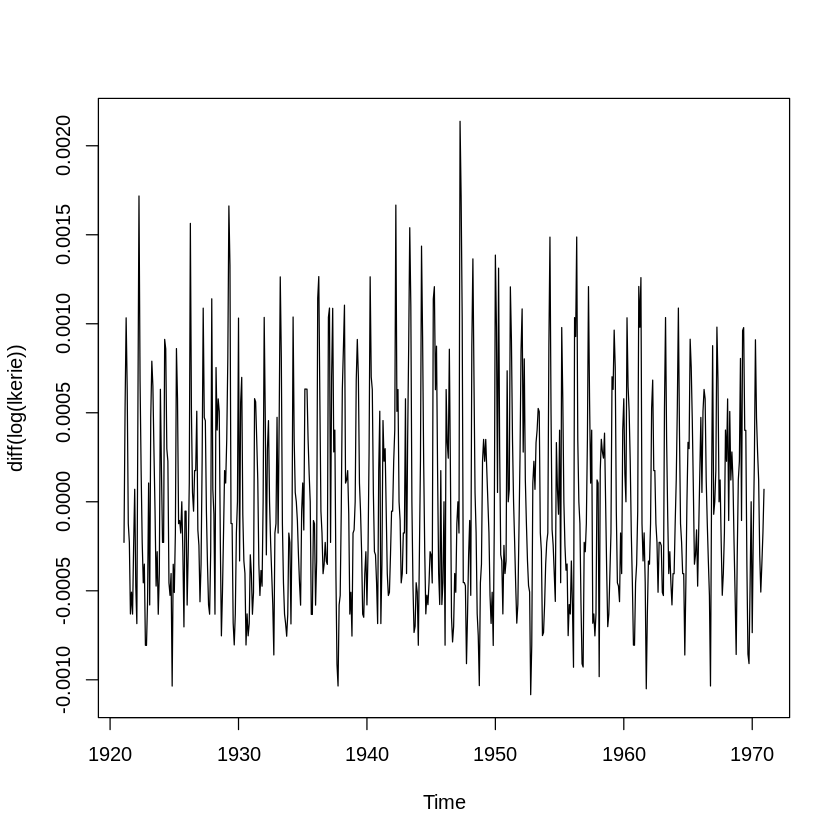

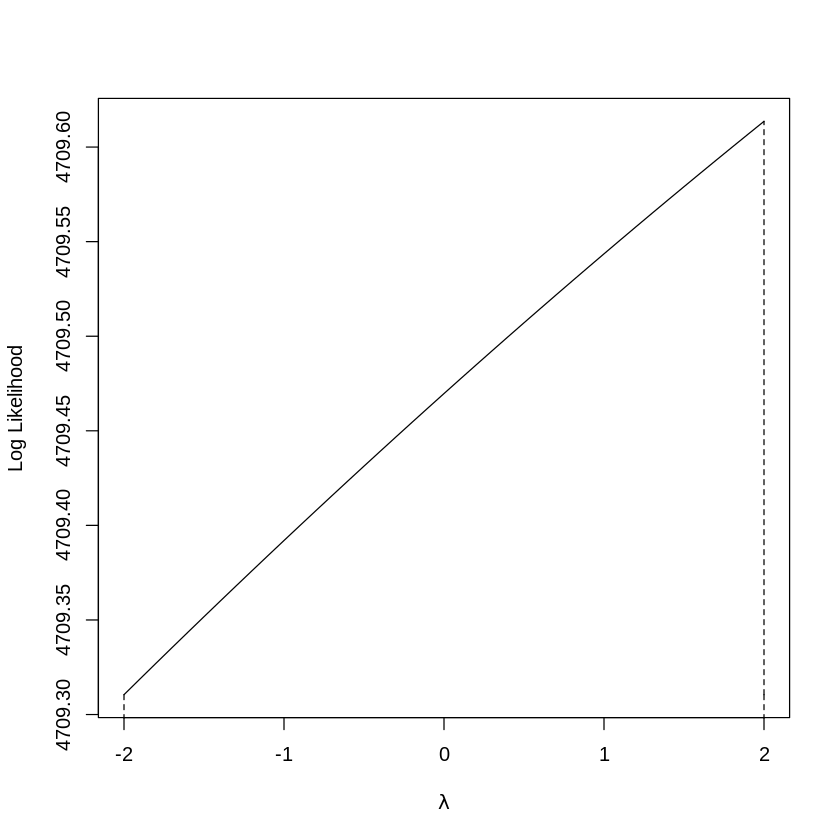

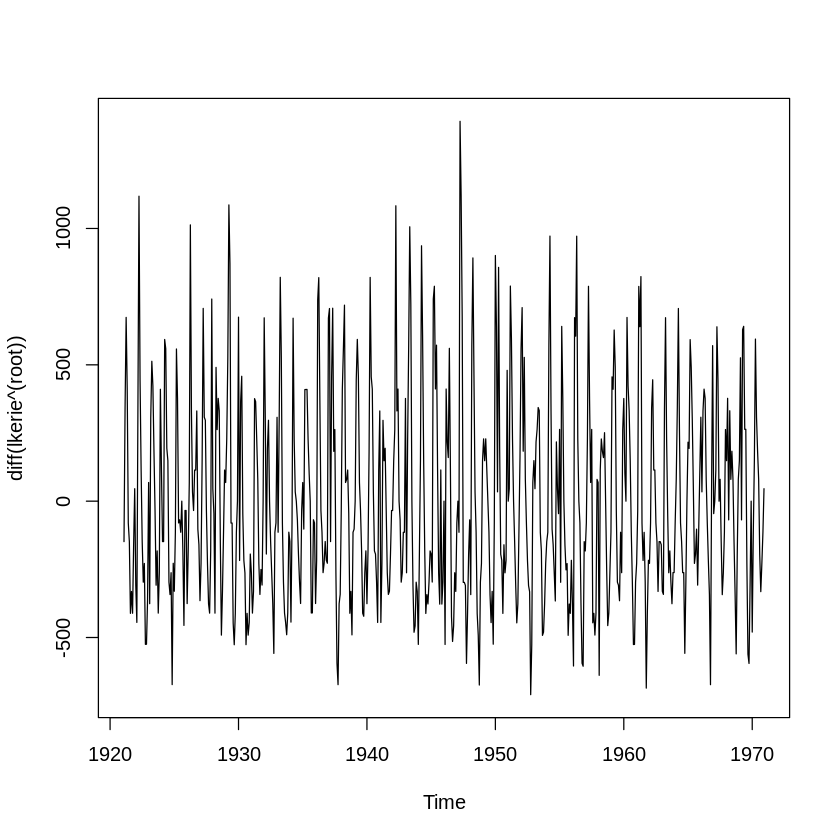

In [13]:
ts.plot(lkerie)
ts.plot(log(lkerie))
ts.plot(diff(lkerie))
ts.plot(diff(log(lkerie)))


BxCx<-BoxCox.ar(lkerie)
root<-BxCx$mle
ts.plot(diff(lkerie^(root)))


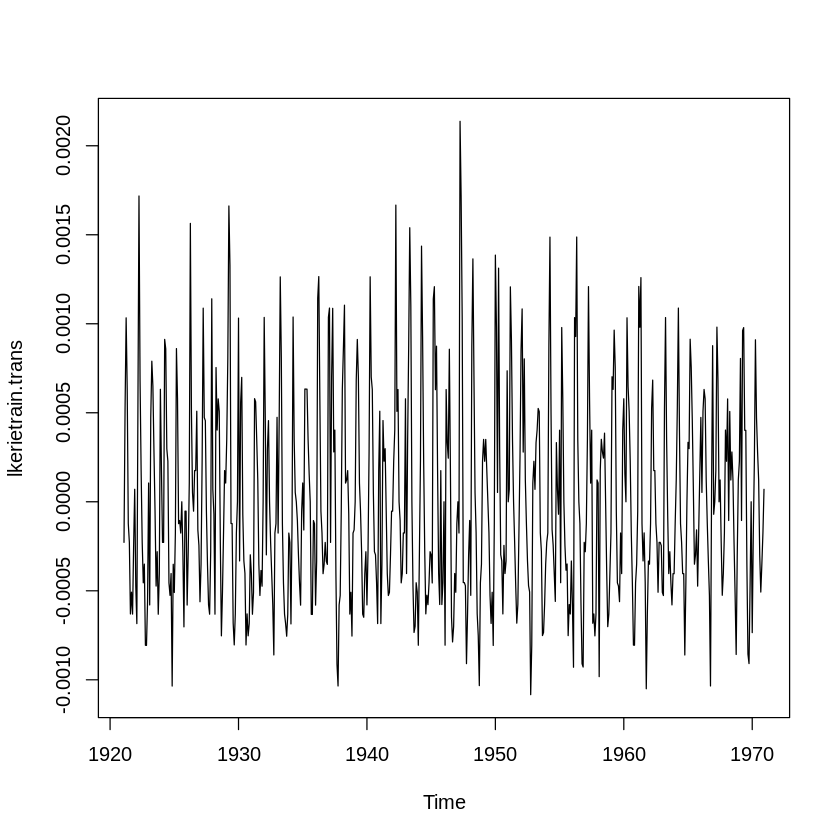

In [14]:
lkerietrain.trans<-diff(log(lkerie))
plot(lkerietrain.trans)

Except for the one outlier just before 1940, we can see that this time series is now stationary, and we can proceed to fit ARIMA models to it.

Using the ACF, PACF and EACF plots, we can see that it will be difficult to find a fitting ARMA (without a seasonal component) model that fits the data well. Since we believe there is a good degree of seasonality to this data, this is not surprising. In the plots below of the ACF and PACF, we see some sine and cosine patterns in the autocorrelations. This indicates a seasonal model may be more appropriate than an ordinary ARMA or ARIMA model.



In [15]:
mean(lkerie)
mean(diff(lkerie))
mean(diff(log(lkerie)),lag=12)
mean(diff(lkerie^root))

[1] 570.7456

[1] 0.001602671

[1] 2.806387e-06

[1] 1.830507

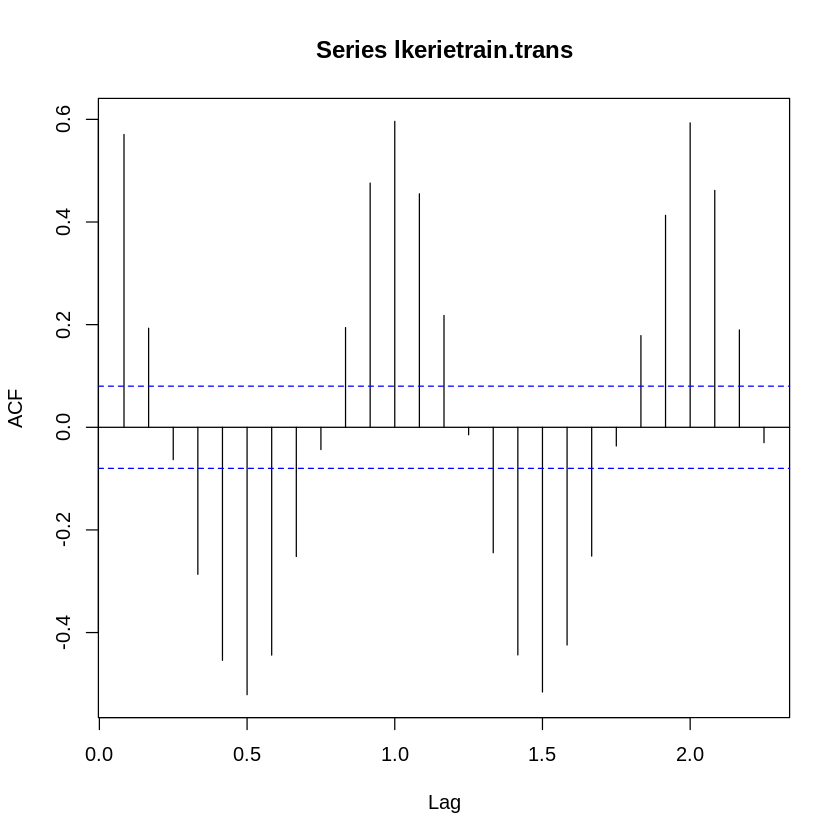

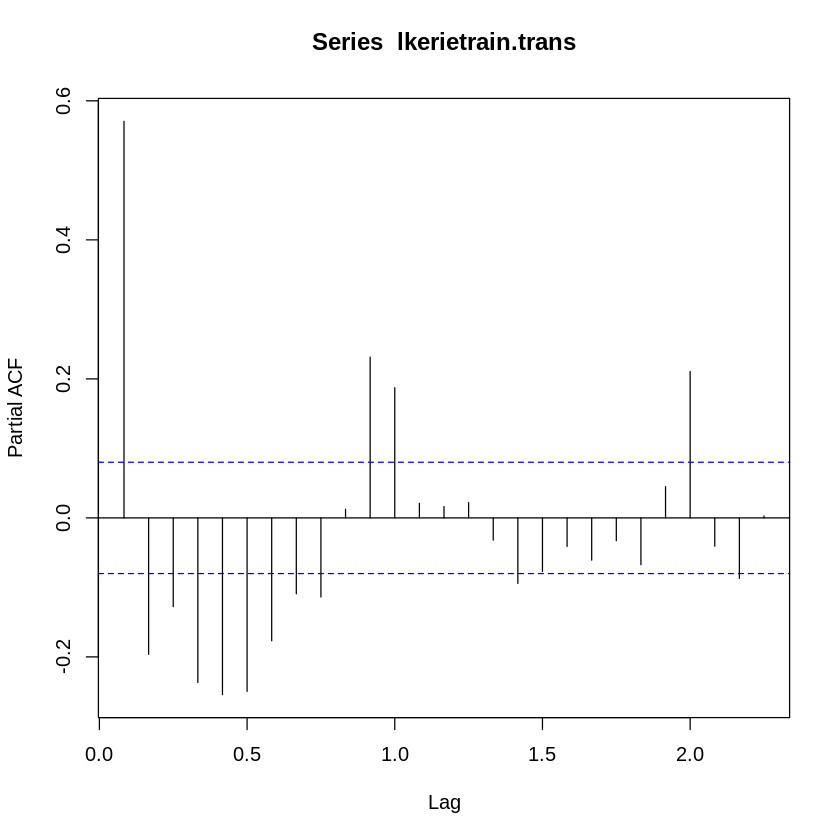

In [16]:
acf(lkerietrain.trans)
pacf(lkerietrain.trans)

Using the arima.subsets function gives us a good idea of the seasonality and we can better infer the best models to use based on this.


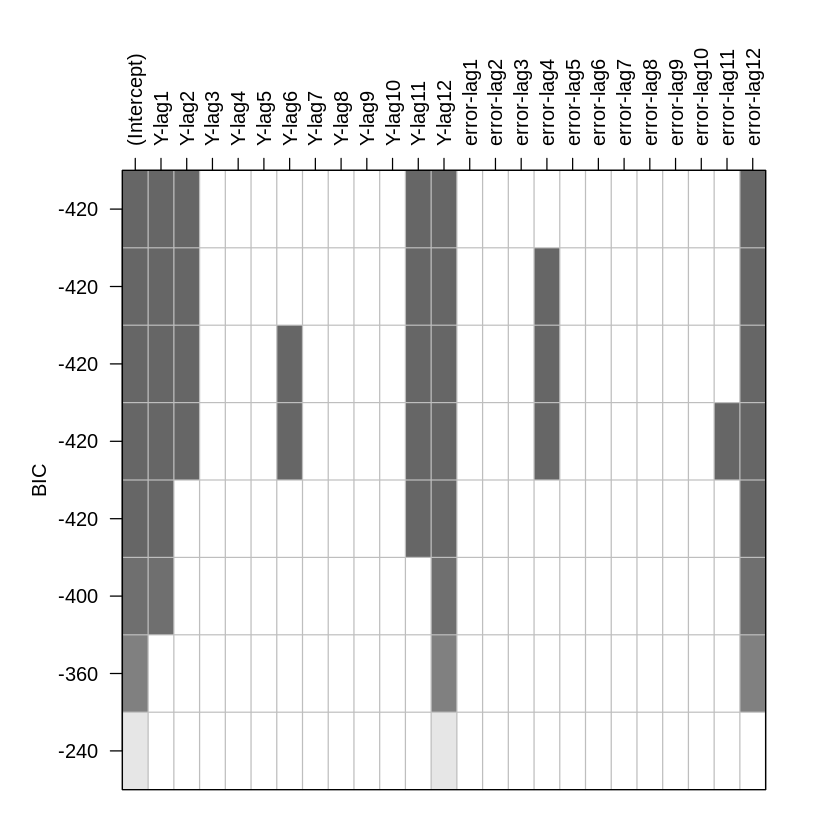

In [17]:
a <- armasubsets(lkerietrain.trans,nar=12,nma=12)
plot(a)

We can see the most significant lags are those at times 1, 11, and 12 for the AR component, and lag 12 for the MA component. Using the auto.arima and get.best.arima functions, we can get the optimal model based on the AIC.


In [18]:
auto.arima(lkerietrain.trans)
get.best.arima(lkerietrain.trans,maxord=c(2,2,2,2,2,2))

Series: lkerietrain.trans 
ARIMA(3,0,0)(2,1,0)[12] 

Coefficients:
         ar1      ar2      ar3     sar1     sar2
      0.3252  -0.0717  -0.0758  -0.7303  -0.3584
s.e.  0.0413   0.0432   0.0412   0.0388   0.0385

sigma^2 estimated as 1.525e-07:  log likelihood=3772.65
AIC=-7533.29   AICc=-7533.15   BIC=-7507.04

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”

[[1]]
[1] -7761.115

[[2]]

Call:
arima(x = x_ts, order = c(p, d, q), seasonal = list(order = c(P, D, Q), frequency(x_ts)), 
    method = "CSS")

Coefficients:
         ma1    sar1     sma1  intercept
      0.2951  0.9918  -0.9040      2e-04
s.e.  0.0375  0.0049   0.0208      3e-04

sigma^2 estimated as 1.315e-07:  part log likelihood = 3895.35

[[3]]
[1] 0 0 1 1 0 1


The get.best.arima’s model produces the minimal AIC, and therefore is the optimal model. We can see it is very similar to the models determined by the subsets, and adds an MA component to the seasonal part of the ARIMA model. I consider both models found (that is, SARIMA[1,0,0]x[2,0,2] and SARIMA[0,0,1]x[2,0,2]). In both models, all of the terms are significant, so there is no need to remove any.

Looking at the residuals of these ARIMA models, we can see that they are roughly normally distributed, with the outliers skewing it somewhat. This is encouraging. Unfortunately, the residuals (and squared residuals) do seem to still exhibit autocorrelation.  However, the ACF and PACF squared do not appear to have drastically more correlated values in the squared case. I have included the Q-Q plot and the ACF of the residuals below. For brevity,

I have omitted the PACF, but it exhibits similar results.
Regardless, this result is disappointing. This led me to use spectral analysis to interpret the seasonality, as I believed there was some underlying seasonal pattern that could not be found using these standard SARIMA processes.



AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x o x x x x x o x x  x  x  x 
1 x x o x x x x x o o x  x  x  x 
2 x x o o o o o o o o o  x  o  o 
3 x x o o o o o o o x o  x  o  o 
4 x x x o o o o o o o o  o  o  o 
5 x x x x o o o o o o o  x  o  o 
6 x x x x o o o o o o o  x  o  o 
7 x x o x o x o o o o o  x  o  o 


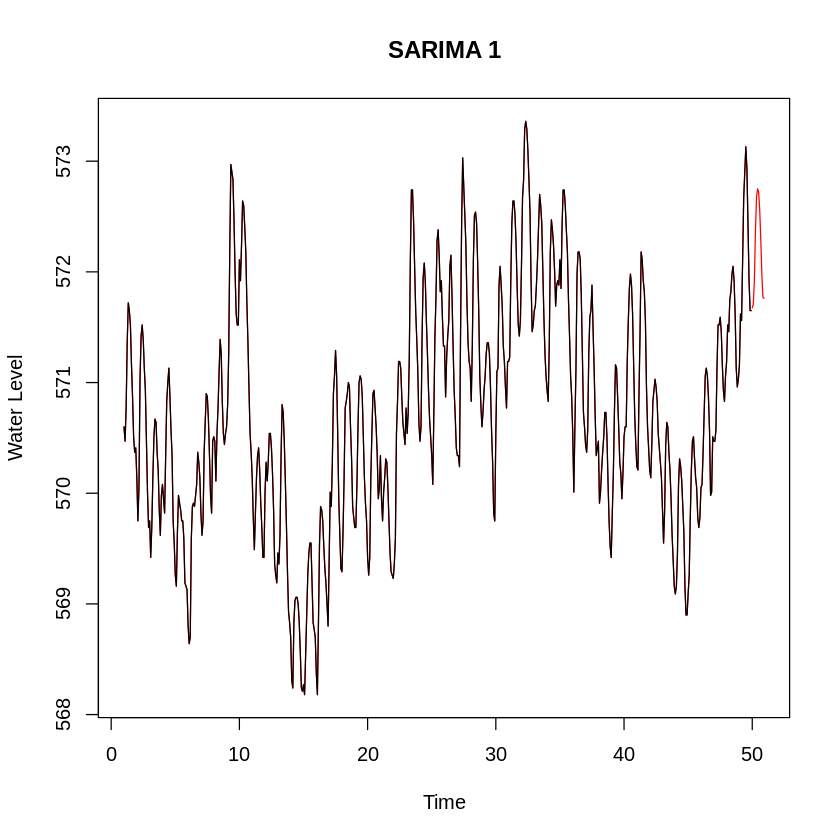

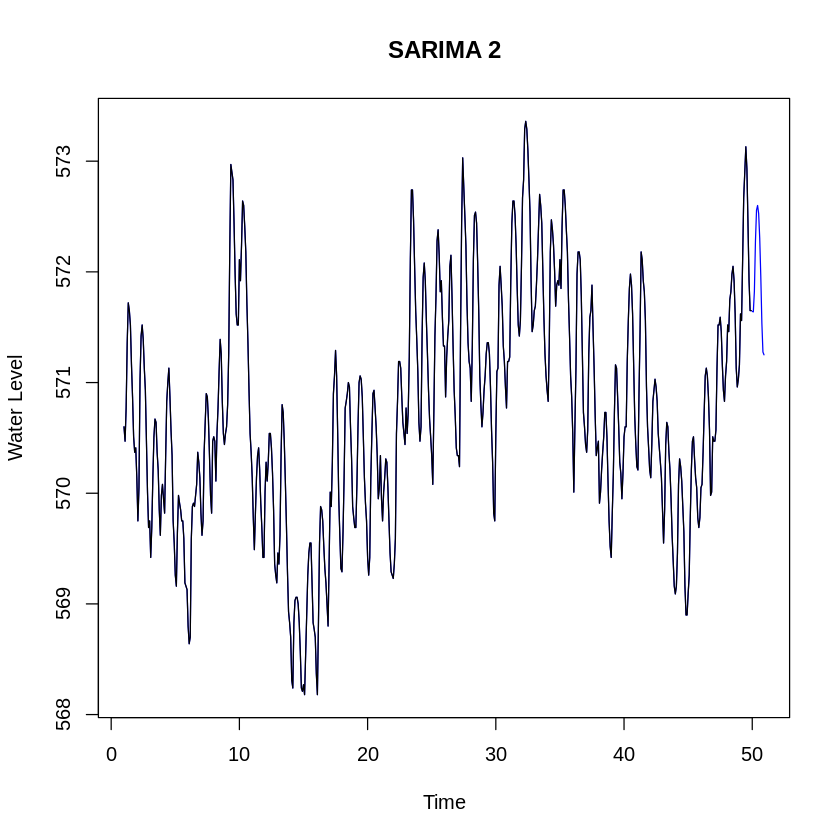

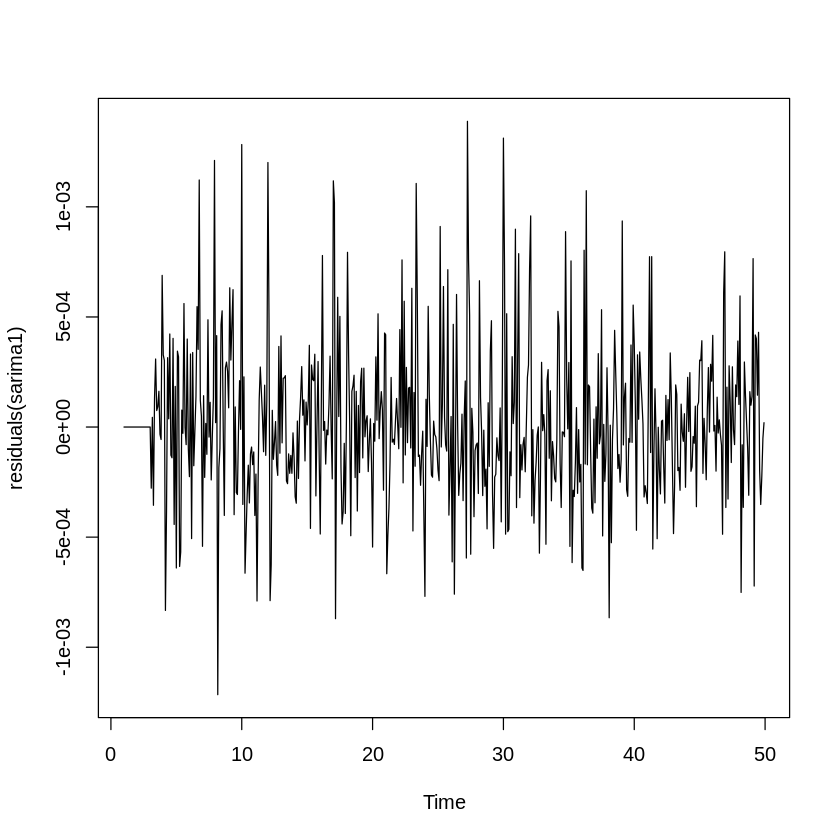

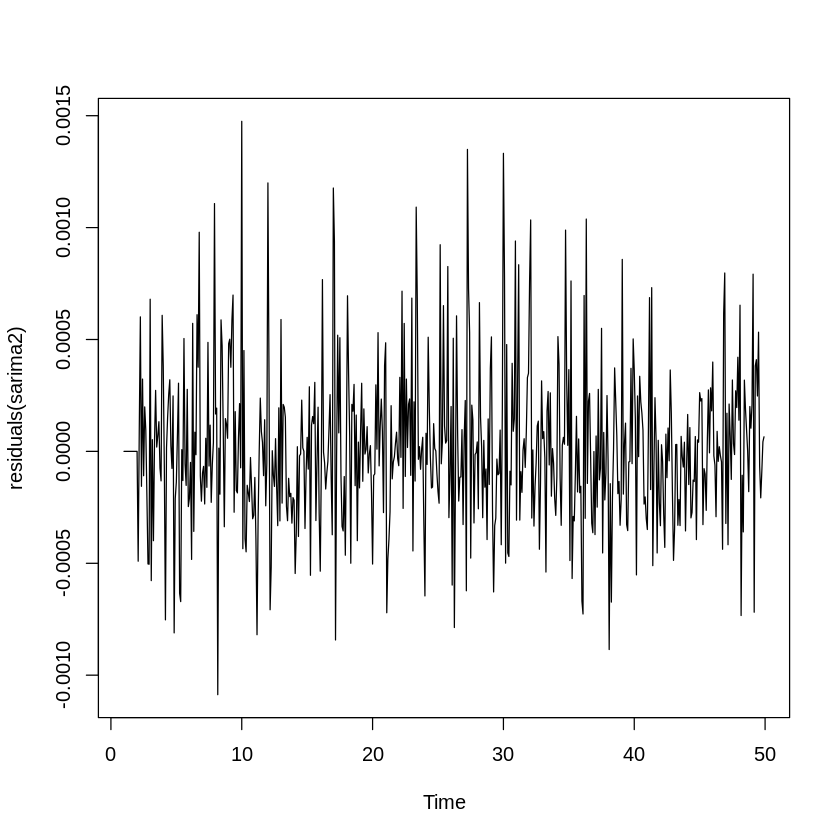

In [19]:
eacf(lkerietrain.trans)

sarima1<-arima(log(lkerietrain), order = c(0, 1, 1), seasonal = list(order = c(2, 0, 2), frequency(lkerietrain)),
               method = "CSS")
sarima2<-arima(log(lkerietrain), order = c(1, 0, 1), seasonal = list(order = c(0, 1, 1), frequency(lkerietrain)),
               method = "CSS")

sarima1pred<-predict(sarima1,n.ahead=12)
sarima2pred<-predict(sarima2,n.ahead=12)

predarima1<-exp(sarima1pred$pred)
predarima2<-exp(sarima2pred$pred)

searima1<-exp(sarima1pred$se)
searima2<-exp(sarima2pred$se)

ts.plot(lkerietrain,predarima1,col="red",main="SARIMA 1",xlab="Time",ylab="Water Level")
lines(x=c(time(lkerie)),c(lkerietrain,(predarima1+1.96*searima1)),col="red",lty="dashed")
lines(x=c(time(lkerie)),c(lkerietrain,(predarima1-1.96*searima1)),col="red",lty="dashed")
lines(lkerietrain)

ts.plot(lkerietrain,predarima2,col="blue",main="SARIMA 2",xlab="Time",ylab="Water Level")
lines(x=c(time(lkerie)),c(lkerietrain,(predarima2+1.96*searima2)),col="blue",lty="dashed")
lines(x=c(time(lkerie)),c(lkerietrain,(predarima2-1.96*searima2)),col="blue",lty="dashed")
lines(lkerietrain)

ssesarima1<-sse(predarima1, lkerietest)
ssesarima2<-sse(predarima2, lkerietest)

plot(residuals(sarima1))
plot(residuals(sarima2))

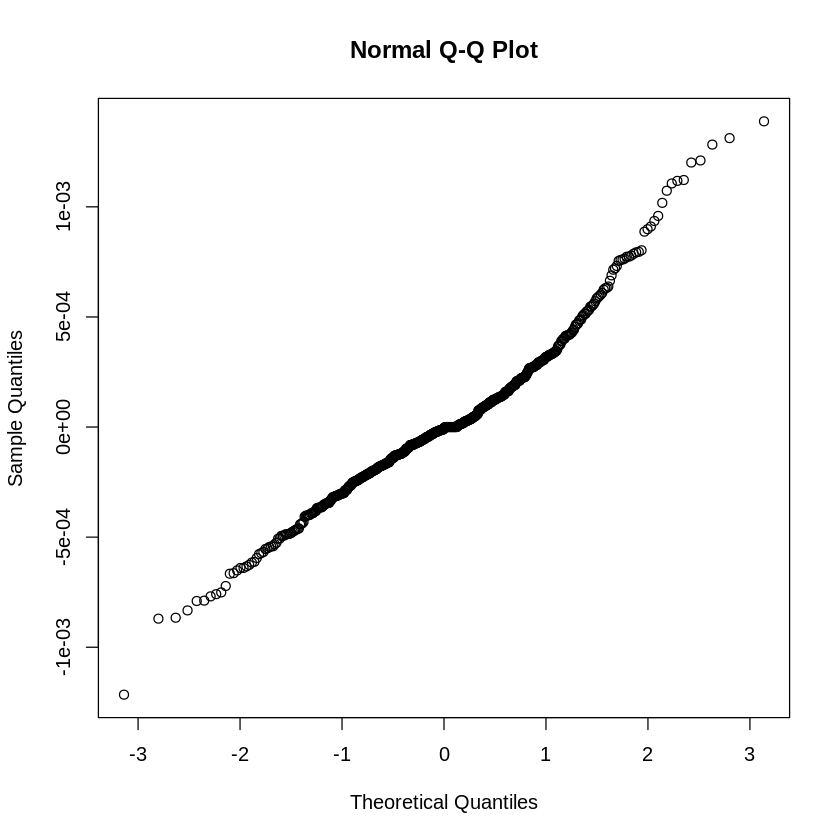

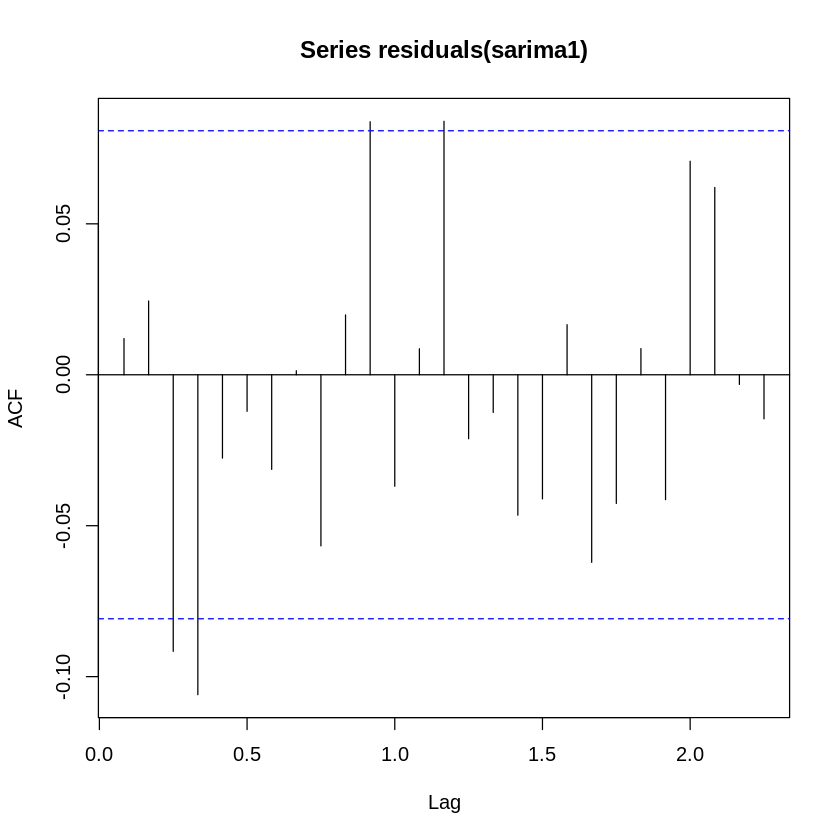

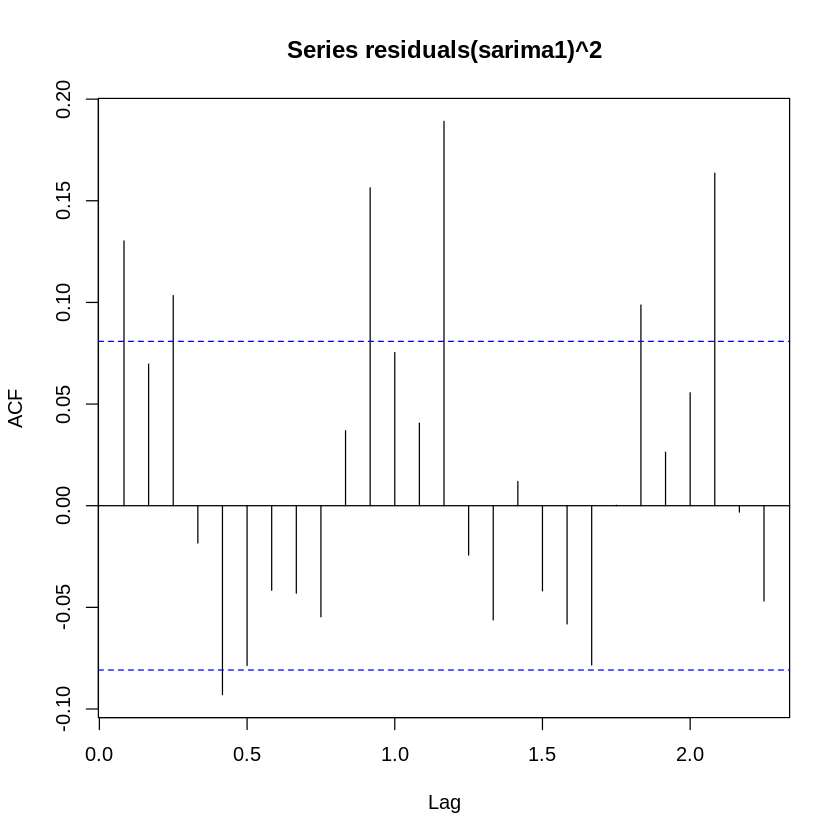

In [20]:
qqnorm(y=residuals(sarima1))
acf(residuals(sarima1))
acf(residuals(sarima1)^2)

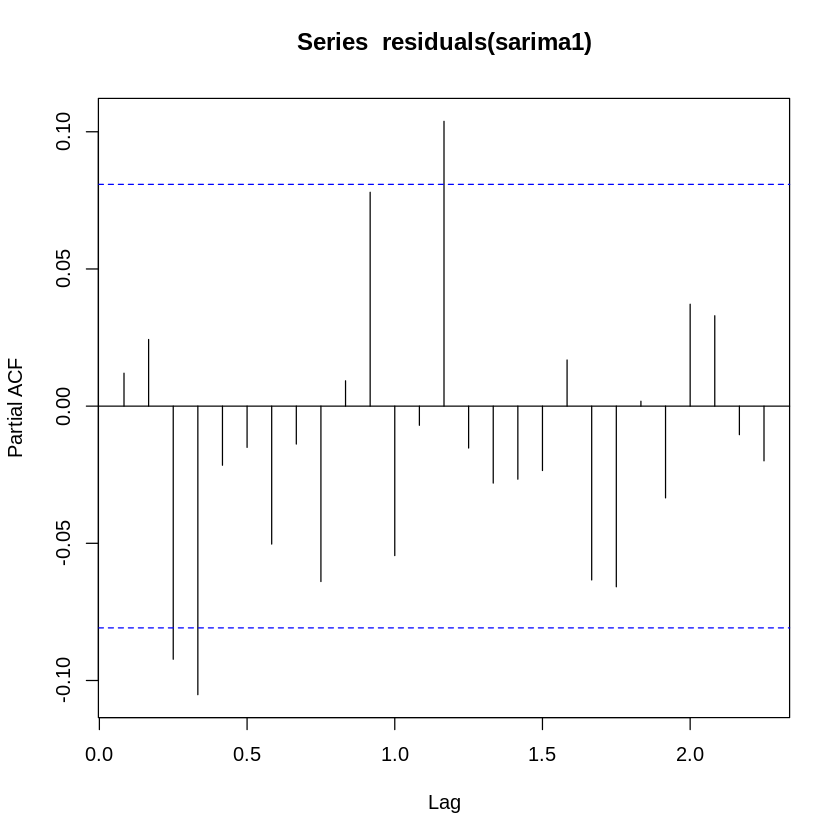

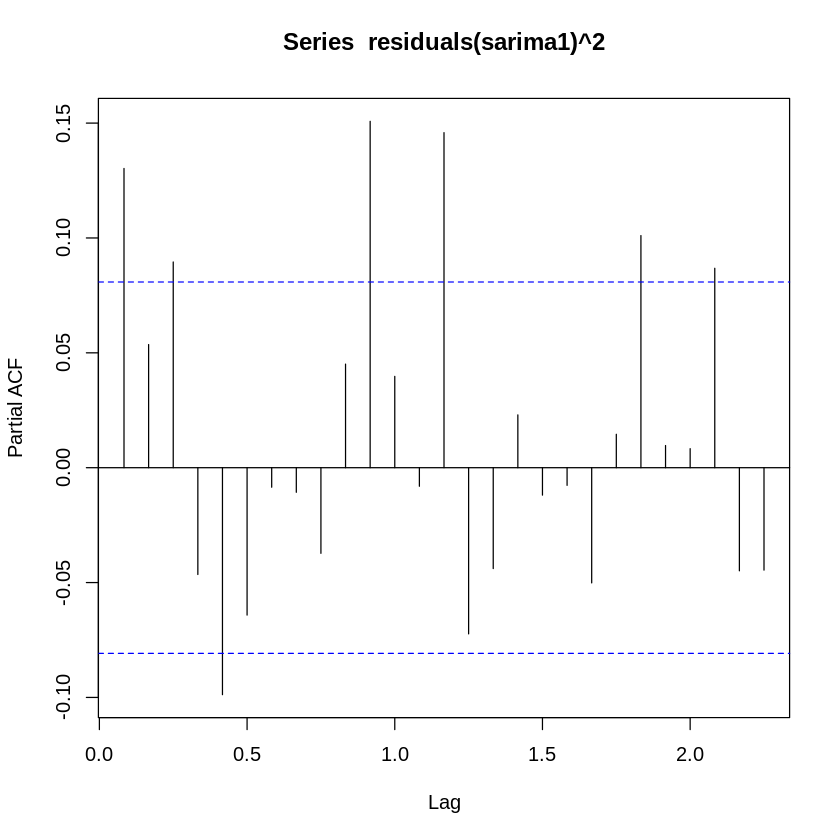

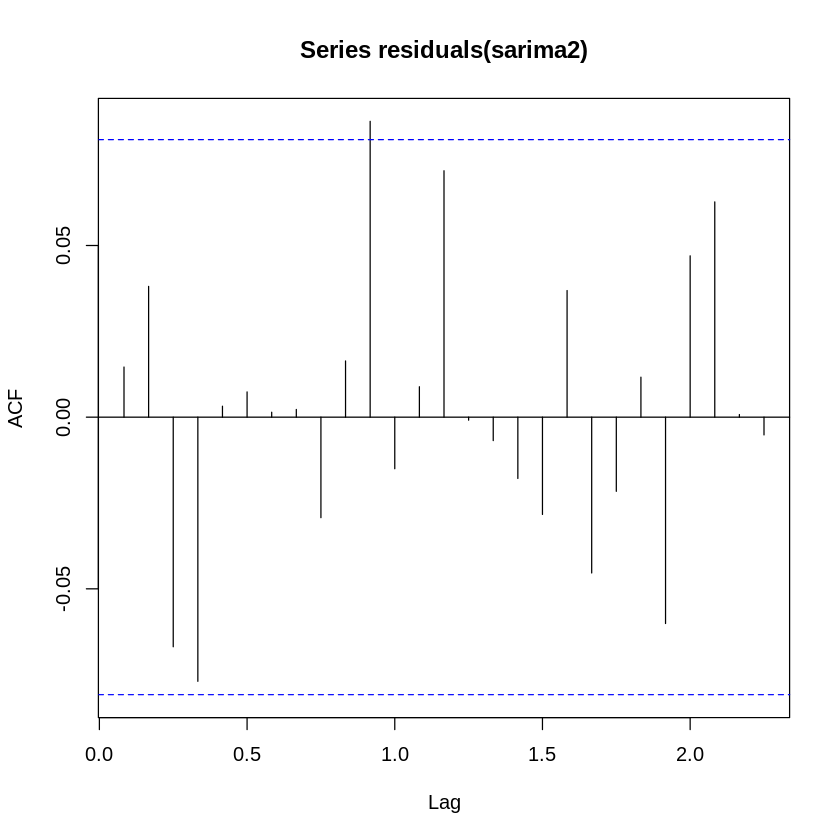

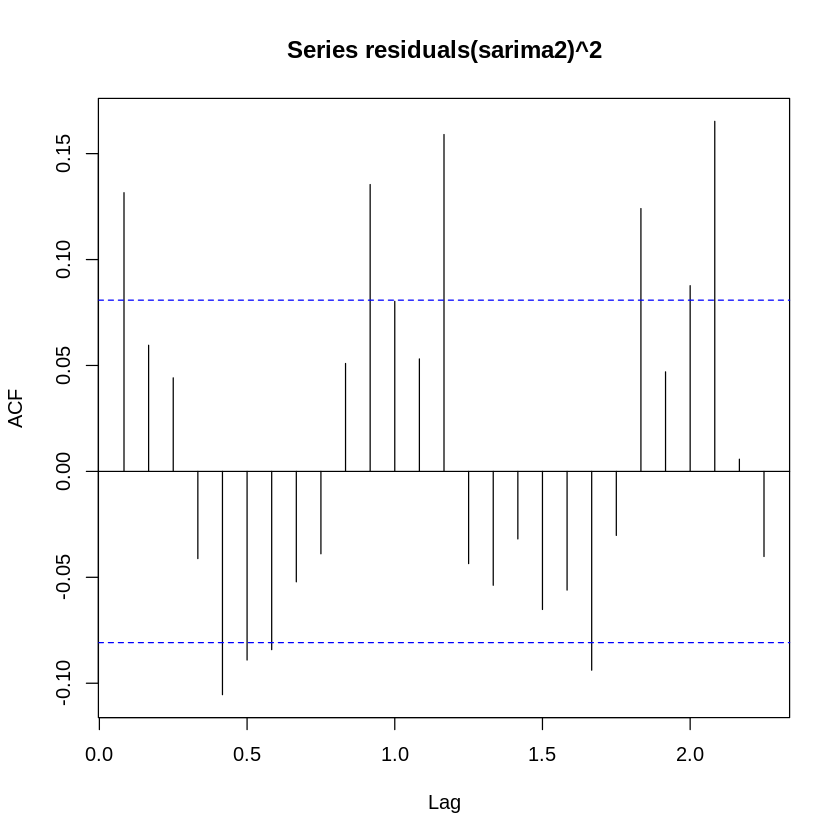

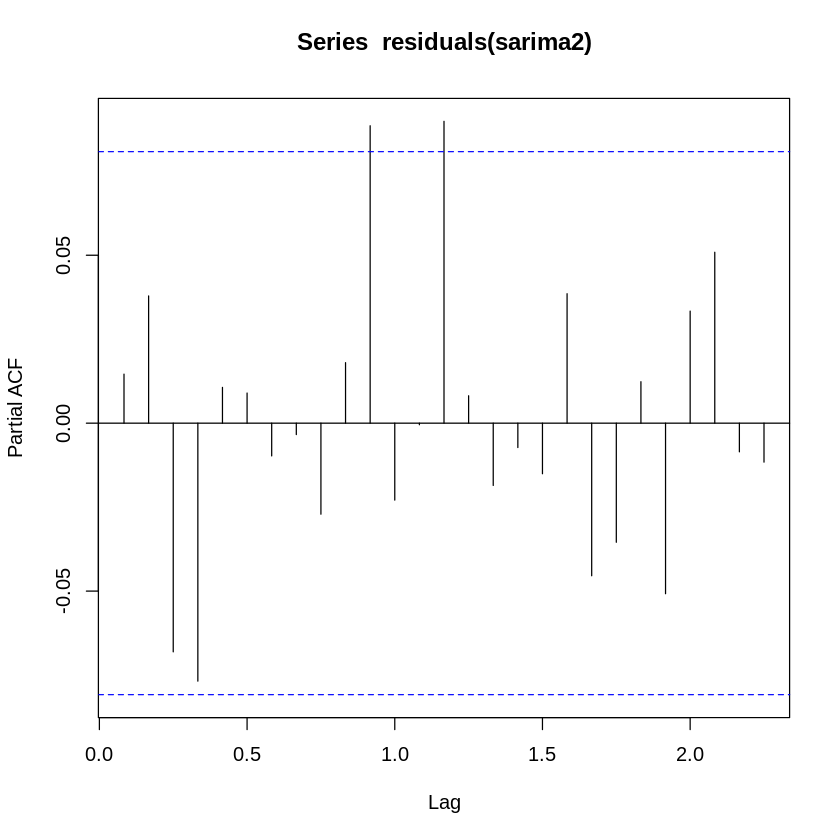

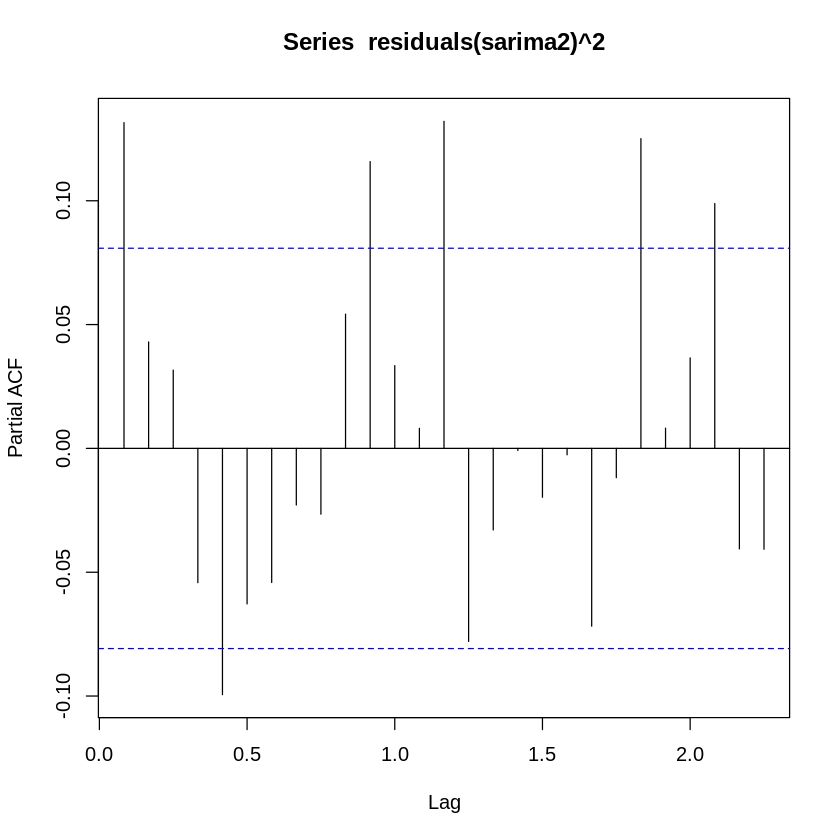

In [21]:
pacf(residuals(sarima1))
pacf(residuals(sarima1)^2)

acf(residuals(sarima2))
acf(residuals(sarima2)^2)
pacf(residuals(sarima2))
pacf(residuals(sarima2)^2)


# Spectral Analysis + ARIMA

The cyclical component of the time series led me to believe that using spectral analysis to analyze the seasonality of the data may be fruitful. The method I used here was to find the highest frequencies on the periodogram, and use these to model the seasonal components.

Using the ten frequencies with this highest spectrum on the log of the time series, I created twenty variables with a sin/cosine function pertaining to each. I then performed linear regression on the transformed time series with these ten values to create a harmonic model.



[1] 588


Call:
lm(formula = log(lkerietrain) ~ cc1 + c2 + c3 + c4 + c5 + c6 + 
    c7 + c8 + c9 + c10 + d1 + d2 + d3 + d4 + d5 + d6 + d7 + d8 + 
    d9 + d10 + t)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.371e-03 -4.185e-04 -4.084e-05  4.940e-04  1.747e-03 

Coefficients:
              Estimate Std. Error   t value Pr(>|t|)    
(Intercept)  6.346e+00  1.536e-04 41304.497  < 2e-16 ***
cc1         -4.134e-04  3.943e-05   -10.483  < 2e-16 ***
c2          -1.104e-03  3.827e-05   -28.837  < 2e-16 ***
c3           6.794e-04  3.941e-05    17.237  < 2e-16 ***
c4           1.714e-04  3.933e-05     4.358 1.56e-05 ***
c5           8.460e-04  3.921e-05    21.575  < 2e-16 ***
c6           6.117e-04  3.928e-05    15.574  < 2e-16 ***
c7           3.266e-04  3.881e-05     8.415 3.22e-16 ***
c8          -3.230e-04  3.914e-05    -8.252 1.10e-15 ***
c9          -2.637e-04  3.906e-05    -6.752 3.62e-11 ***
c10          6.280e-05  3.836e-05     1.637  0.10221    
d1          -5.615e-04

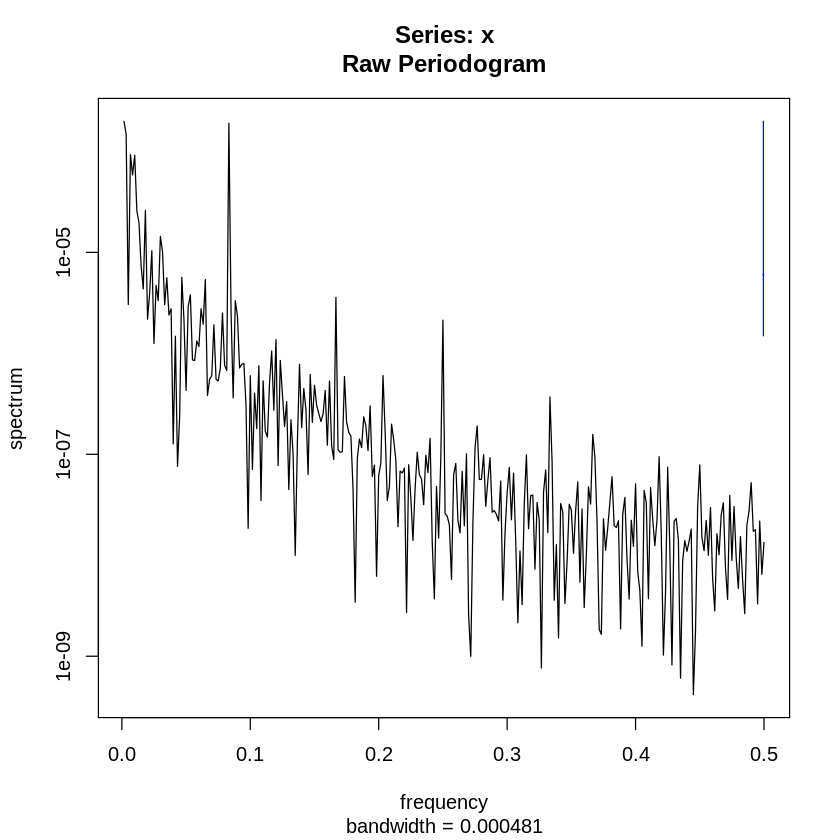

In [22]:
spec.per<-spec(log(lkerietrain))
frequencies<-spec.per$freq[order(spec.per$spec,decreasing=TRUE)]
t<-1:length((log(lkerietrain)))
length(t)
cc1<-as.numeric(cos(2*pi*frequencies[1]*t))
d1<-sin(2*pi*frequencies[1]*t)
c2<-cos(2*pi*frequencies[2]*t)
d2<-sin(2*pi*frequencies[2]*t)
c3<-cos(2*pi*frequencies[3]*t)
d3<-sin(2*pi*frequencies[3]*t)
c4<-cos(2*pi*frequencies[4]*t)
d4<-sin(2*pi*frequencies[4]*t)
c5<-cos(2*pi*frequencies[5]*t)
d5<-sin(2*pi*frequencies[5]*t)
c6<-cos(2*pi*frequencies[6]*t)
d6<-sin(2*pi*frequencies[6]*t)
c7<-cos(2*pi*frequencies[7]*t)
d7<-sin(2*pi*frequencies[7]*t)
c8<-cos(2*pi*frequencies[8]*t)
d8<-sin(2*pi*frequencies[8]*t)
c9<-cos(2*pi*frequencies[9]*t)
d9<-sin(2*pi*frequencies[9]*t)
c10<-cos(2*pi*frequencies[10]*t)
d10<-sin(2*pi*frequencies[10]*t)




spec.m1<-lm(log(lkerietrain)~cc1+c2+c3+c4+c5+c6+c7+c8+c9+c10+d1+d2+d3+d4+d5+d6+d7+d8+d9+d10+t)
summary(spec.m1)


The results here are very significant, with a very high R-squared (.8804). We can see that the plot below produced a moderately good fit, considering it is just a sum of sine and cosine waves. However, the danger of overfitting is present. To mitigate this issue, I used the training data and a ARIMA (1,0,1) to find the sum squared errors related to different amounts of frequencies. We can see that the error plateaus at 2 frequencies. I used frequencies of 2 and 4 to create these fits. I then used these frequencies as a prediction of the seasonal components.



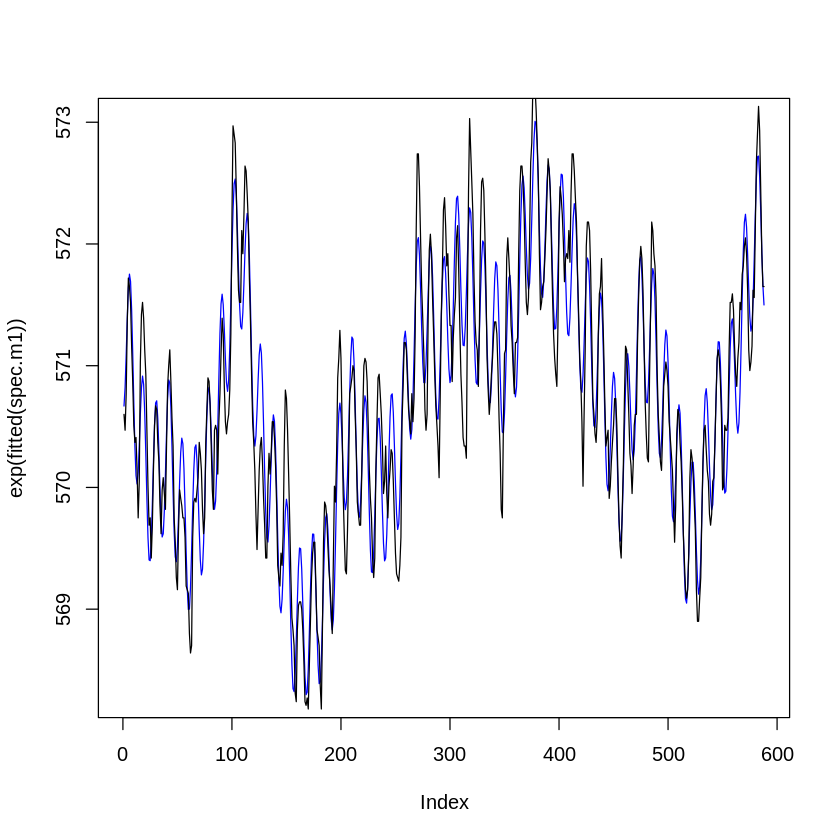

In [23]:
plot(exp(fitted(spec.m1)),type="l",col="blue")
lines(t,lkerietrain)

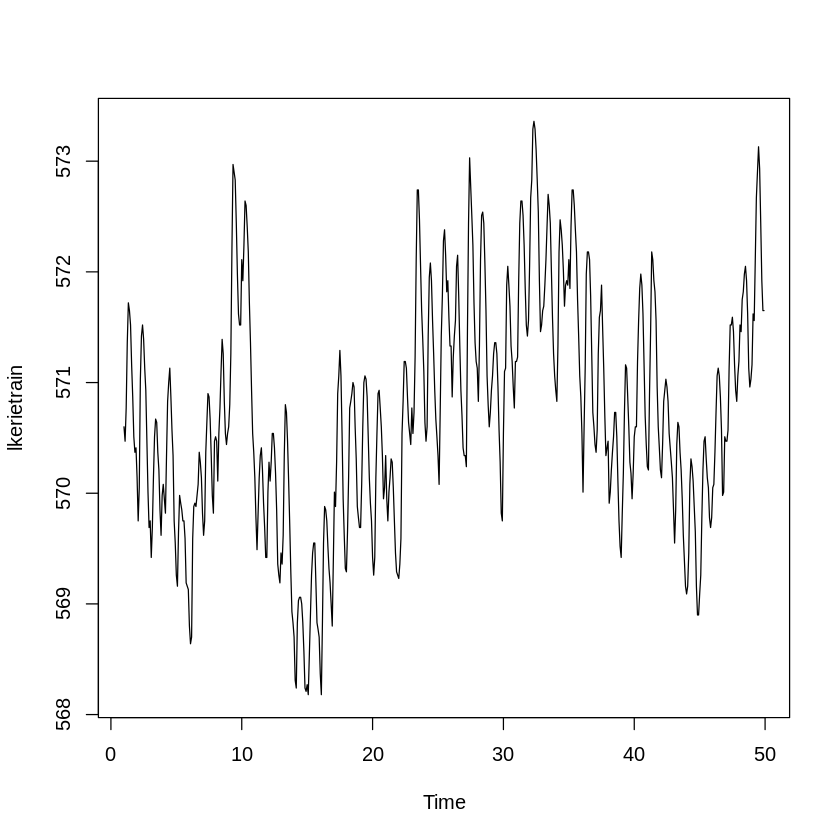

In [24]:
test<-cbind(c(589:600),cos(2*pi*frequencies[1]*(589:600)),
            sin(2*pi*frequencies[1]*(589:600)),
            cos(2*pi*frequencies[2]*(589:600)),
            sin(2*pi*frequencies[2]*(589:600)),
            cos(2*pi*frequencies[3]*(589:600)),
            sin(2*pi*frequencies[3]*(589:600)),
            cos(2*pi*frequencies[4]*(589:600)),
            sin(2*pi*frequencies[4]*(589:600)),
            cos(2*pi*frequencies[5]*(589:600)),
            sin(2*pi*frequencies[5]*(589:600)),
            cos(2*pi*frequencies[6]*(589:600)),
            sin(2*pi*frequencies[6]*(589:600)),
            cos(2*pi*frequencies[7]*(589:600)),
            sin(2*pi*frequencies[7]*(589:600)),
            cos(2*pi*frequencies[8]*(589:600)),
            sin(2*pi*frequencies[8]*(589:600)),
            cos(2*pi*frequencies[9]*(589:600)),
            sin(2*pi*frequencies[9]*(589:600)),
            cos(2*pi*frequencies[10]*(589:600)),
            sin(2*pi*frequencies[10]*(589:600)))

colnames(test)=c("t","cc1","d1","c2","d2","c3","d3","c4","d4","c5","d5","c6","d6","c7","d7","c8","d8","c9","d9","c10","d10")

plot(lkerietrain)
models<-list()

In [25]:
for(i in 1:10){
  beg<-"cc1+d1"
  if(i>1){
    for(s in 2:i){
      beg<-paste(beg,paste("c",s,sep=""),paste("d",s,sep=""),sep="+")
    }
  }
  end<-paste(beg,"t",sep="+")
  models[[i]]<-lm(formula(paste("log(lkerietrain)","~",end,sep="")))
  pre<-exp(fitted(models[[i]]))
  sub<-lkerietrain-exp(fitted(models[[i]]))
  arimasub<-Arima(sub, order=c(1,0,1))
  print(i)
  print(sum(((arimasub$fitted+pre)-lkerietrain)^2))
}

[1] 1
[1] 42.29154
[1] 2
[1] 27.36564
[1] 3
[1] 26.89214
[1] 4
[1] 26.63287
[1] 5
[1] 25.86952
[1] 6
[1] 25.1265
[1] 7
[1] 24.43297
[1] 8
[1] 24.10715
[1] 9
[1] 23.83364
[1] 10
[1] 23.4628


In [26]:
summary(models[[2]])
summary(models[[4]])##c4 is insignificant, remove it
models[[4]]<-lm(log(lkerietrain)~cc1+c2+c3+d1+d2+d3+d4+t)


Call:
lm(formula = formula(paste("log(lkerietrain)", "~", end, sep = "")))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0030522 -0.0009396 -0.0000317  0.0008021  0.0046639 

Coefficients:
              Estimate Std. Error   t value Pr(>|t|)    
(Intercept)  6.347e+00  1.822e-04 34832.880  < 2e-16 ***
cc1         -5.413e-04  8.497e-05    -6.371 3.83e-10 ***
d1          -1.220e-03  1.389e-04    -8.786  < 2e-16 ***
c2          -1.100e-03  8.384e-05   -13.122  < 2e-16 ***
d2          -2.828e-04  8.386e-05    -3.373 0.000793 ***
t           -1.070e-06  5.851e-07    -1.829 0.067857 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001437 on 582 degrees of freedom
Multiple R-squared:  0.3927,	Adjusted R-squared:  0.3875 
F-statistic: 75.27 on 5 and 582 DF,  p-value: < 2.2e-16



Call:
lm(formula = formula(paste("log(lkerietrain)", "~", end, sep = "")))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0027355 -0.0007332 -0.0001049  0.0008003  0.0036466 

Coefficients:
              Estimate Std. Error   t value Pr(>|t|)    
(Intercept)  6.346e+00  2.050e-04 30958.858  < 2e-16 ***
cc1         -4.664e-04  6.620e-05    -7.044 5.32e-12 ***
d1          -4.834e-04  1.442e-04    -3.351 0.000857 ***
c2          -1.104e-03  6.497e-05   -16.991  < 2e-16 ***
d2          -2.688e-04  6.501e-05    -4.136 4.07e-05 ***
c3           6.267e-04  6.618e-05     9.470  < 2e-16 ***
d3           1.055e-03  9.067e-05    11.641  < 2e-16 ***
c4           1.202e-04  6.608e-05     1.819 0.069362 .  
d4          -6.514e-04  7.133e-05    -9.133  < 2e-16 ***
t            2.811e-06  6.783e-07     4.144 3.92e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001114 on 578 degrees of freedom
Multiple R-squared:  0.6378,	A

Using the models with 2 and 4 frequencies, I subtracted these fitted spectral models from the original time series. As the plots are very similar in nature, I will only produce one of them here:


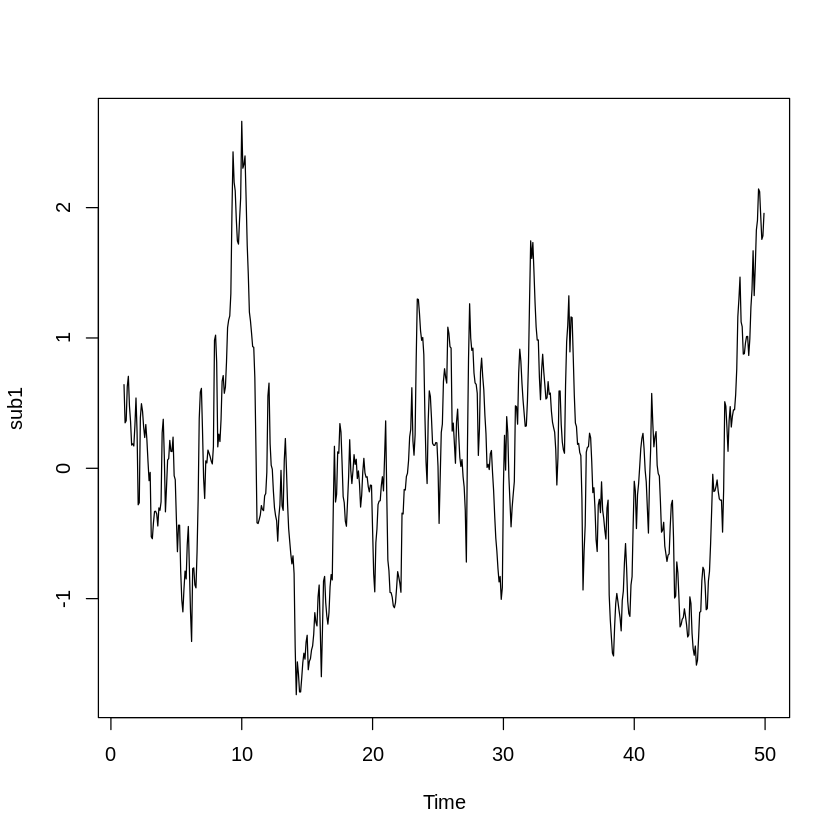

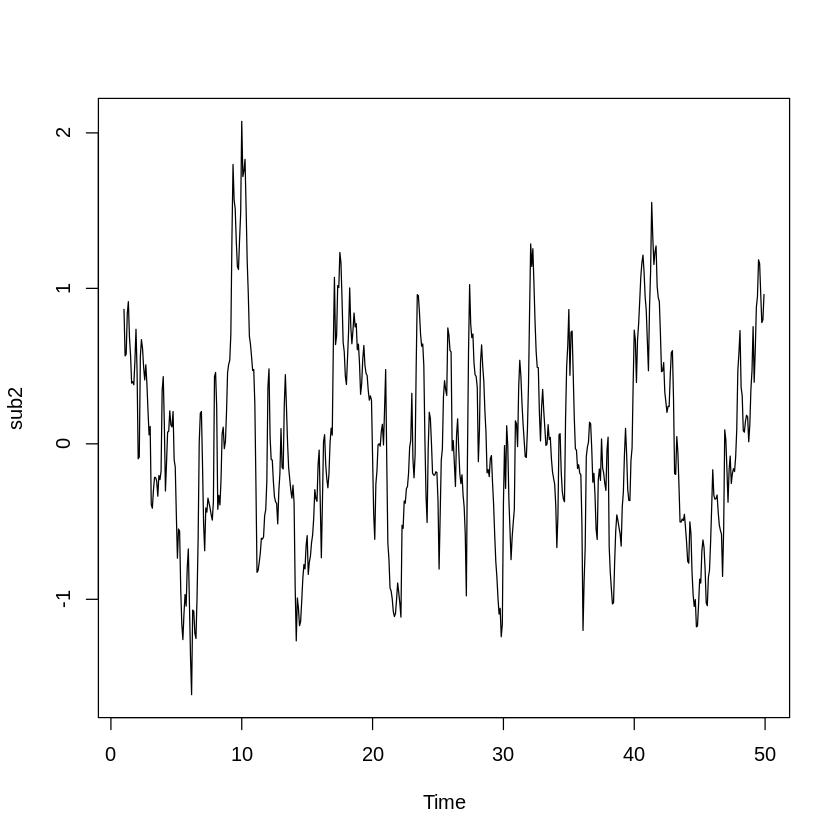

In [27]:
sub1<-lkerietrain-exp(fitted(models[[2]]))
sub2<-lkerietrain-exp(fitted(models[[4]]))
plot(sub1)
plot(sub2)

This produced two time series that are very reminiscent of random noise, which is what is expected, as this was to remove the seasonal component from the data. After a similar analysis to this data to the above SARIMA models, I arrived at two models to fit this ‘white noise’ like data, SARIMA[1,0,1]x[0,1,1] for the first and SARIMA[2,1,1]x[1,0,1] for the second (the code is included in the appendix, but this result had the smallest AIC from the get.best.arima() function.)


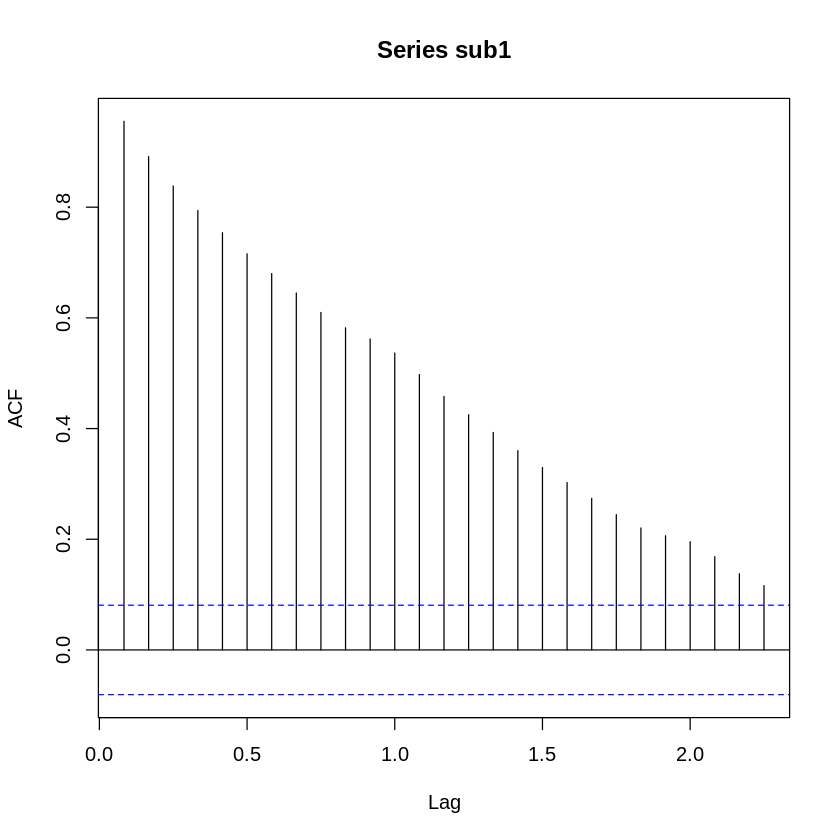

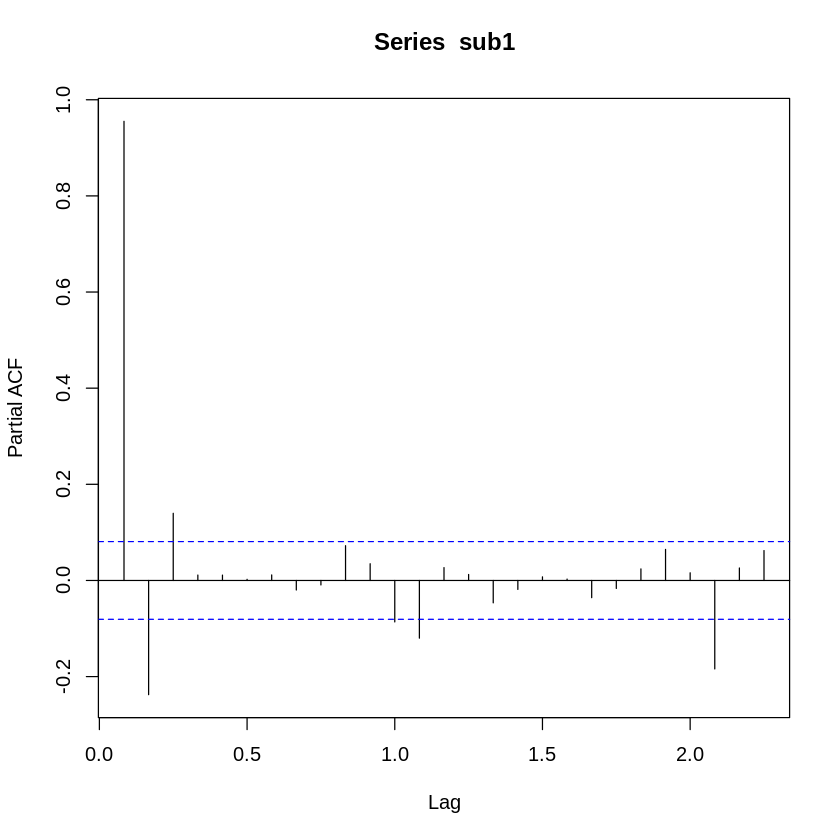

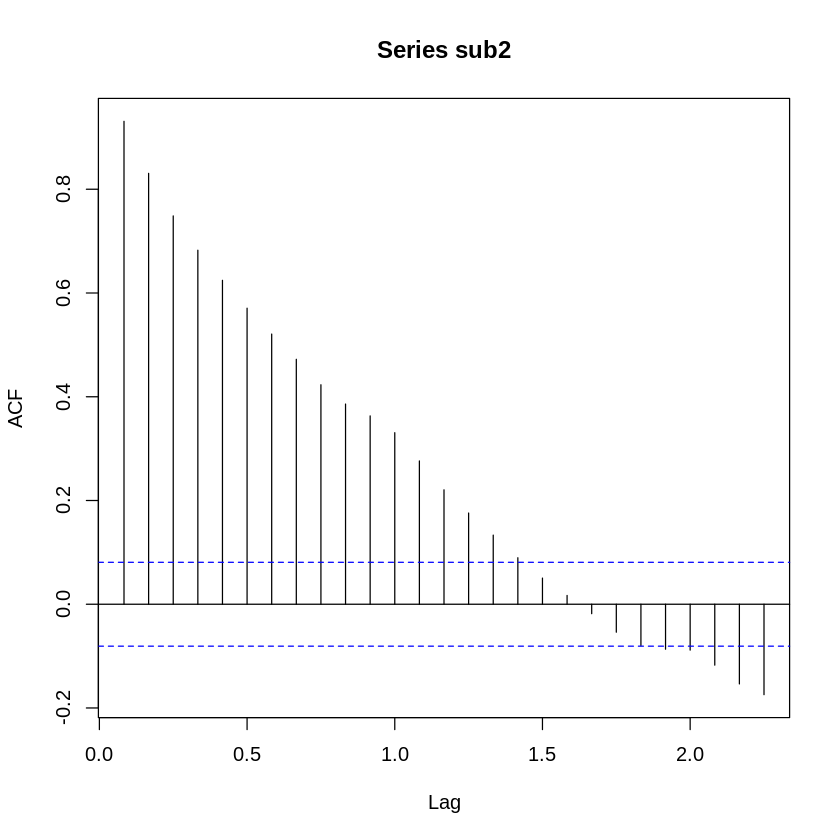

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x x x x x x x x x  x  x  x 
1 x x x o o o o o o x x  x  o  o 
2 x x o o o o o o o o o  x  x  o 
3 x x o o o o o o o o o  x  x  o 
4 x x o o o o o o o o o  o  o  o 
5 o x o o o o o o o o o  o  o  o 
6 x o x o o o o o o o o  x  o  o 
7 x x o o o o o o o o o  x  o  o 
AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x x x x x x x x x  x  x  x 
1 x o x o o o o o o x x  x  x  o 
2 x x o o o o o o o o o  x  x  o 
3 o x o o o o o o o o o  x  x  o 
4 x x o o o o o o o o o  o  o  o 
5 x x o o o o o o o o o  o  o  o 
6 x o x o o o o o o o o  x  o  o 
7 o x o x o o o o o o o  o  o  o 


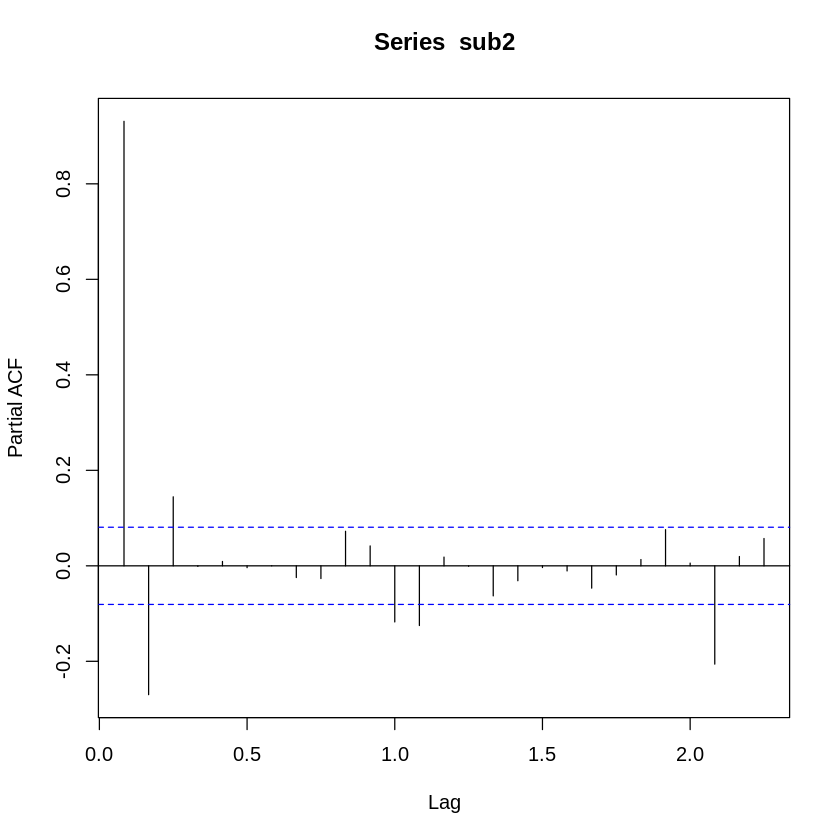

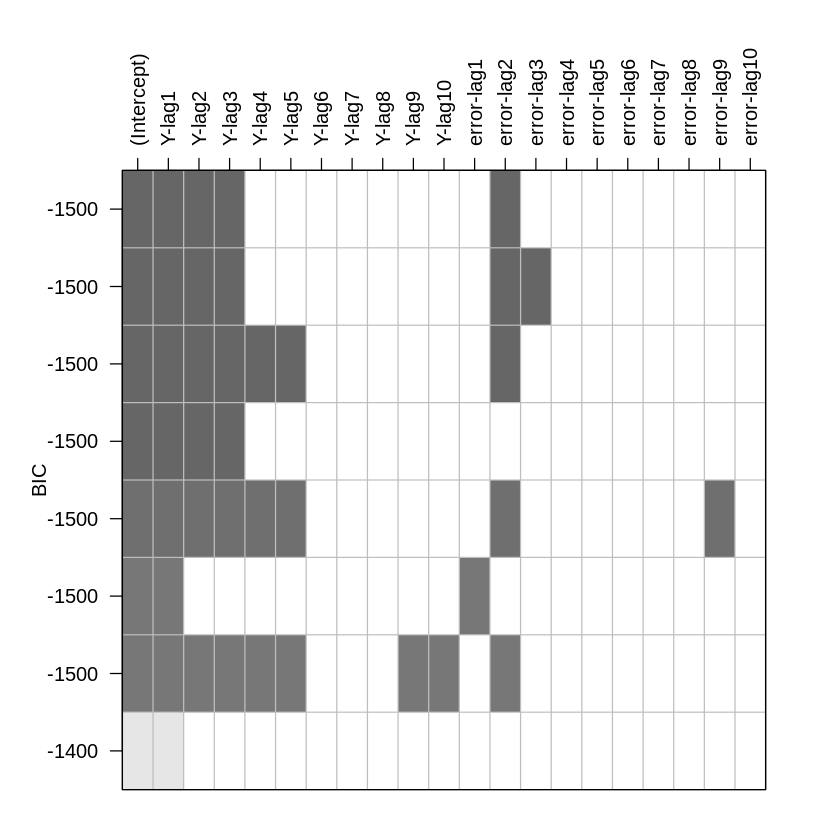

Series: sub1 
ARIMA(1,0,2)(2,0,0)[12] with zero mean 

Coefficients:
         ar1     ma1     ma2    sar1    sar2
      0.9309  0.3420  0.0113  0.1461  0.1965
s.e.  0.0172  0.0457  0.0474  0.0412  0.0415

sigma^2 estimated as 0.04377:  log likelihood=85.88
AIC=-159.77   AICc=-159.63   BIC=-133.51

Series: sub2 
ARIMA(1,0,1)(2,0,0)[12] with zero mean 

Coefficients:
         ar1     ma1    sar1    sar2
      0.9032  0.3462  0.1385  0.1797
s.e.  0.0187  0.0399  0.0409  0.0416

sigma^2 estimated as 0.04297:  log likelihood=91.14
AIC=-172.28   AICc=-172.17   BIC=-150.39

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”

[[1]]
[1] -169.6077

[[2]]

Call:
arima(x = x_ts, order = c(p, d, q), seasonal = list(order = c(P, D, Q), frequency(x_ts)), 
    method = "CSS")

Coefficients:
         ar1      ar2    sar1     sma1  intercept
      1.2697  -0.3110  0.9526  -0.8858     0.3867
s.e.  0.0393   0.0394  0.0149   0.0307     0.5862

sigma^2 estimated as 0.04121:  part log likelihood = 103.25

[[3]]
[1] 2 0 0 1 0 1


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”

[[1]]
[1] -185.2687

[[2]]

Call:
arima(x = x_ts, order = c(p, d, q), seasonal = list(order = c(P, D, Q), frequency(x_ts)), 
    method = "CSS")

Coefficients:
         ar1      ar2    sar1     sma1  intercept
      1.2491  -0.3189  0.9536  -0.8916     0.0008
s.e.  0.0391   0.0391  0.0138   0.0277     0.3225

sigma^2 estimated as 0.04013:  part log likelihood = 111.08

[[3]]
[1] 2 0 0 1 0 1


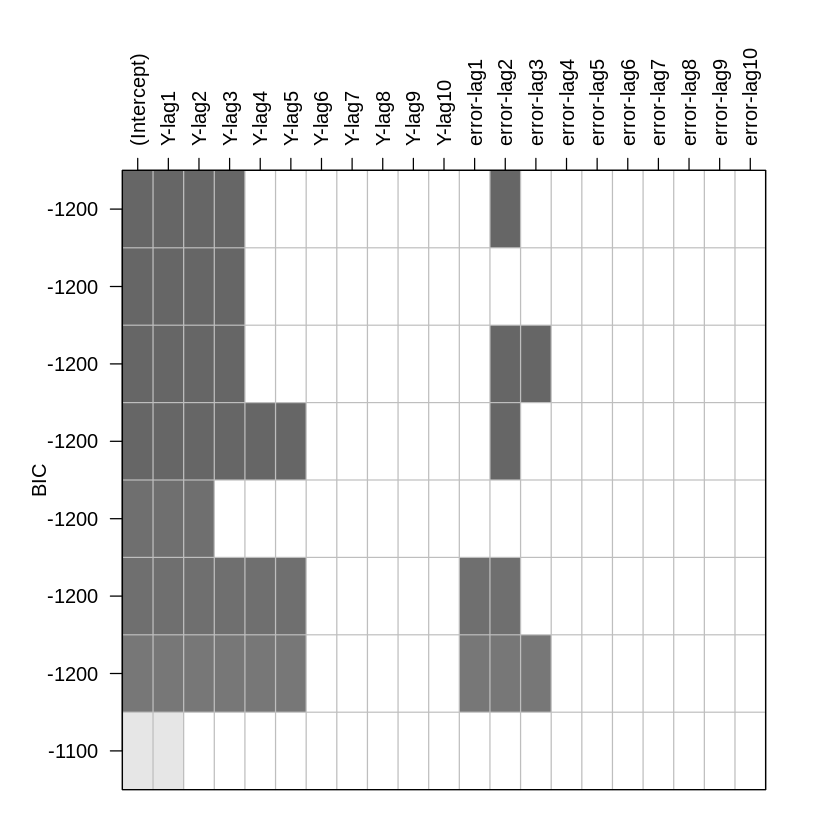

In [28]:
acf(sub1)
pacf(sub1)
acf(sub2)
pacf(sub2)

eacf(sub1)
eacf(sub2)

plot(armasubsets(sub1,nar=10,nma=10))
plot(armasubsets(sub2,nar=10,nma=10))

auto.arima(sub1)
auto.arima(sub2)

get.best.arima(sub1,c(2,2,2,2,2,2))
get.best.arima(sub2,c(2,2,2,2,2,2))

a1spec1<-Arima(sub1,c(1,0,1))
a2spec1<-auto.arima(sub1)

a1spec2<-Arima(sub2,c(1,0,1))
a2spec2<-auto.arima(sub2)
a3spec1<-Arima(y = sub1, order = c(1, 0, 1), seasonal = c(0, 1, 1),
               method = "CSS")
a3spec2<-Arima(y = sub2, order = c(2, 1, 1), seasonal = c(1, 0, 1),
               method = "CSS")

The plots below show that the residuals for the first model are relatively normal and that they do not exhibit very high auto-correlation or partial auto-correlation in the squared cases, which suggests that a these ARIMA models are sufficient, and a GARCH model is unneccessary.


In [29]:
resid1<-residuals(a3spec1)
resid2<-residuals(a3spec2)

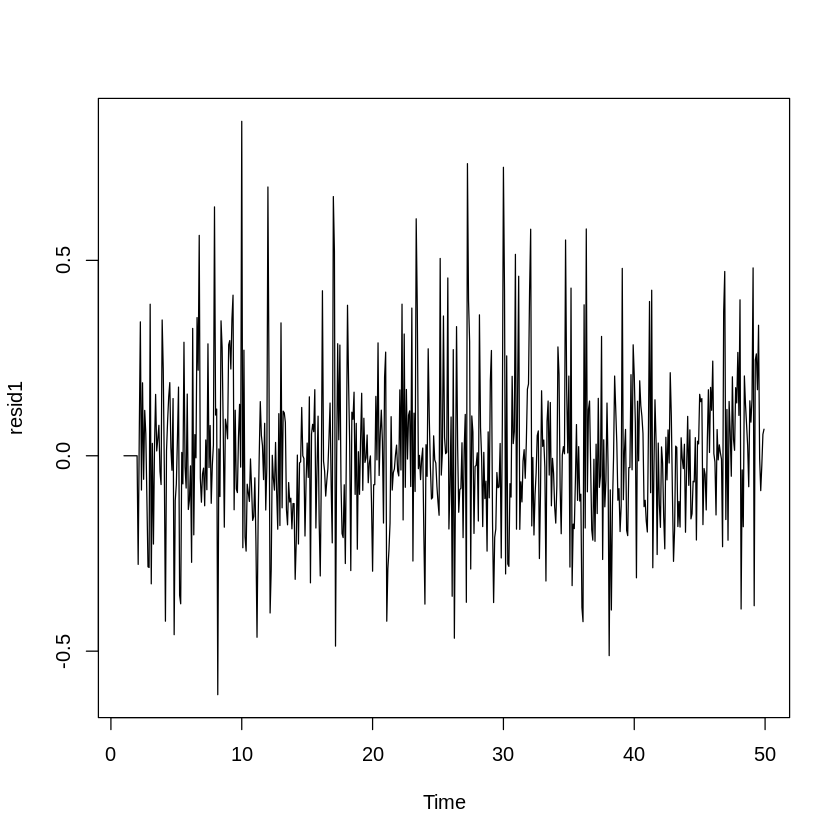

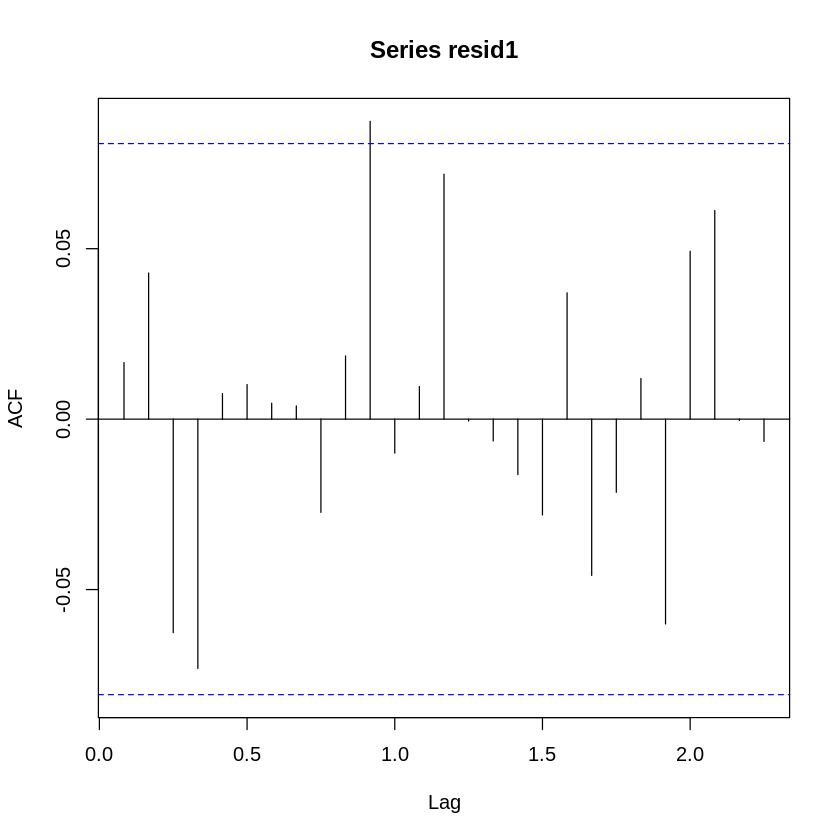

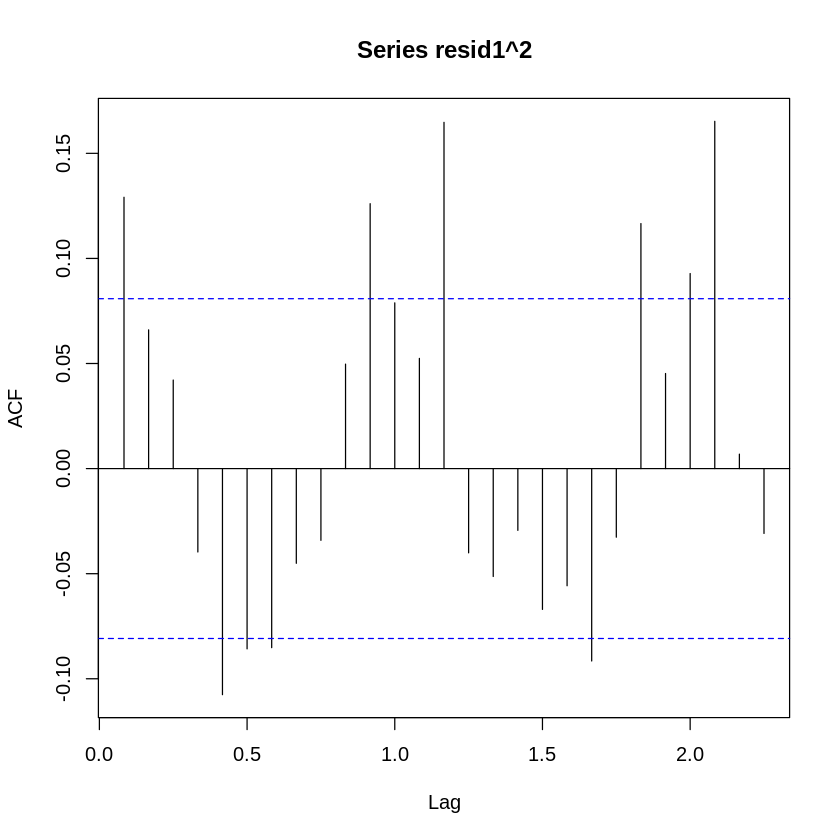

In [30]:
plot(resid1)
acf(resid1)
acf(resid1^2)

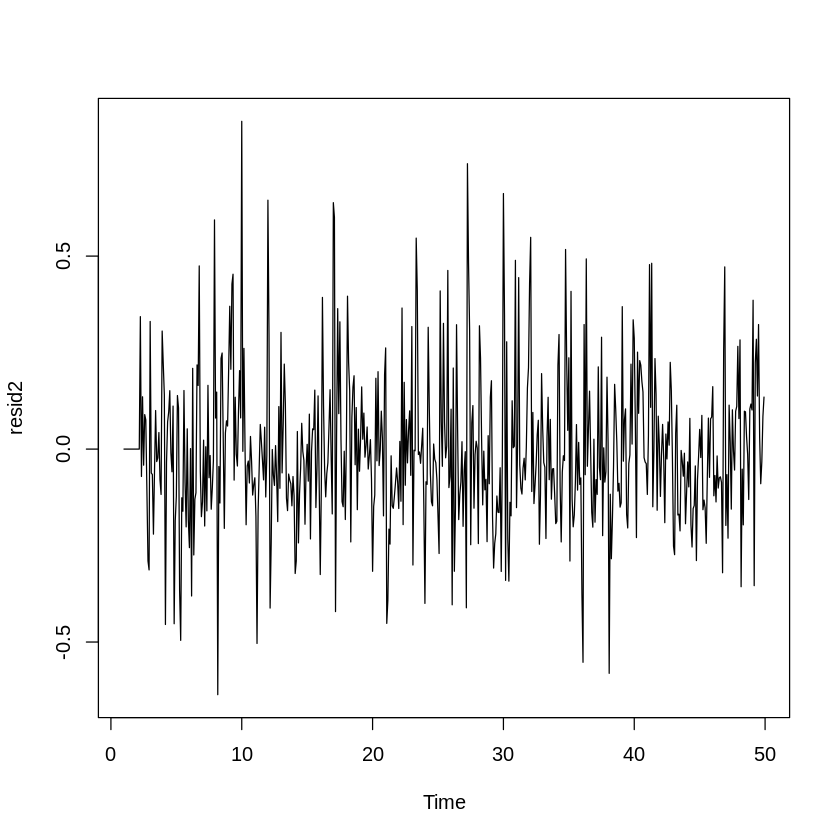

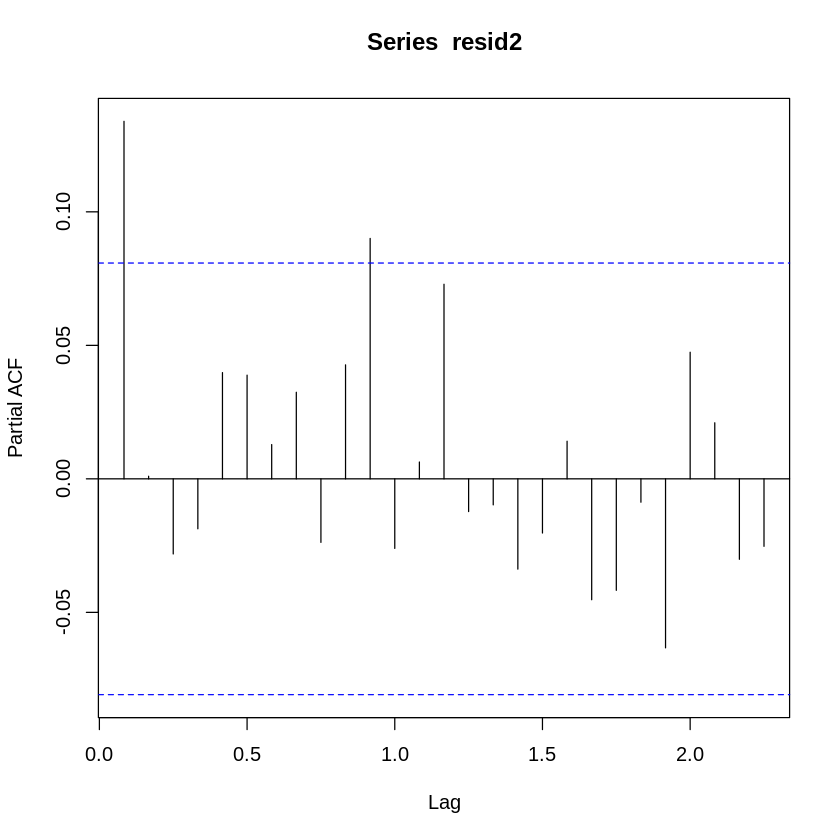

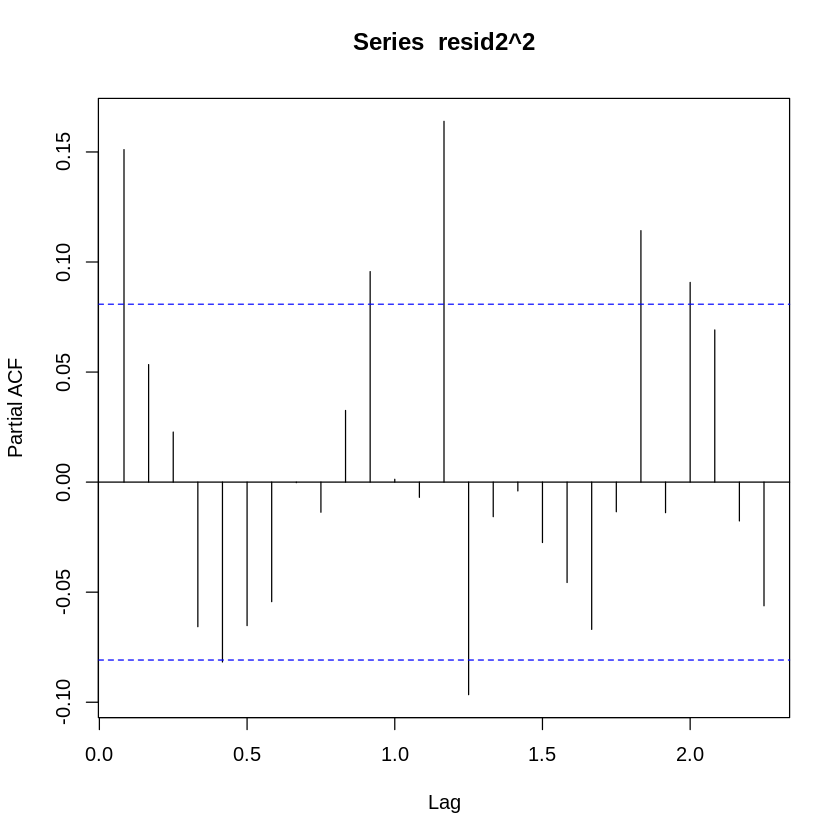

In [31]:
plot(resid2)
pacf(resid2)
pacf(resid2^2)

In [32]:

# Predictions
specpred1<-exp(predict(models[[2]],newdata=as.data.frame(test)))
specpred2<-exp(predict(models[[4]],newdata=as.data.frame(test)))

arimapred1<-predict(a3spec1,n.ahead=12)$pred
arimapred2<-predict(a3spec2,n.ahead=12)$pred

arimase1<-predict(a3spec1,n.ahead=12)$se
arimase2<-predict(a3spec2,n.ahead=12)$se

finalpred1<-specpred1+arimapred1
finalpred2<-specpred2+arimapred2

ssesp1<-sse(finalpred1, lkerietest)
ssesp2<-sse(finalpred2, lkerietest)

ssesp1/12
ssesp2/12

Warning message in predict.Arima(a3spec2, n.ahead = 12):
“MA part of model is not invertible”Warning message in predict.Arima(a3spec2, n.ahead = 12):
“MA part of model is not invertible”

[1] 0.1464569

[1] 0.1275691

# Prophet
The final model that I considered was one produced by Facebook’s prophet package for R. All that is needed is to initialize the data and set it up appropriately. Although the prophet package is somewhat of a “black box” – and it is most effective on daily data – I thought it would be interesting to include it and see how it performs as compared with the other models.


In [40]:
ds <- as.Date(lkerietrain)
y<-as.numeric((log(lkerietrain)))
df<-data.frame(ds,y)
prop<-prophet(df,weekly.seasonality=TRUE)

future <- make_future_dataframe(prop, period = 12,freq="m")
forecast <- prophet:::predict.prophet(prop, future)
fitproph<-exp((forecast$yhat)[1:(length(forecast$yhat)-12)])
predproph<-exp((forecast$yhat)[(length(forecast$yhat)-11):length(forecast$yhat)])
confintup<-exp((forecast$yhat_upper)[(length(forecast$yhat)-11):length(forecast$yhat)])
confintlow<-confintup<-exp((forecast$yhat_lower)[(length(forecast$yhat)-11):length(forecast$yhat)])

sseproph<-sse(predproph, lkerietest)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


# Results
Below is a table representing the sum squared errors of each of the models when forecasting for the next 12 months. These are the errors of each model in comparison to the test data.





In [41]:
results<-data.frame(c(ssehw1,ssehw2,ssesarima1,ssesarima2,ssesp1,ssesp2,sseproph))
colnames(results)<-"SSE"
rownames(results)<-(c("HW 1","HW 2","SARIMA 1","SARIMA 2","Spec 1","Spec 2","Prophet"))
results

,SSE
HW 1,2.216213
HW 2,2.222284
SARIMA 1,2.842606
SARIMA 2,1.682859
Spec 1,1.757483
Spec 2,1.530829
Prophet,2.811629


We can see that the models which use the frequencies from spectral analysis to remove the seasonal components are the best at predicting the data. This makes sense, as many geophysical processes can be modeled well using the sin and cosine waves in spectral analysis. Besides these two models, the SARIMA 2 model predicted with the least error. Below, I produce a plot which shows all the models’ predictions as well as the true values for the time series.


[1] 600

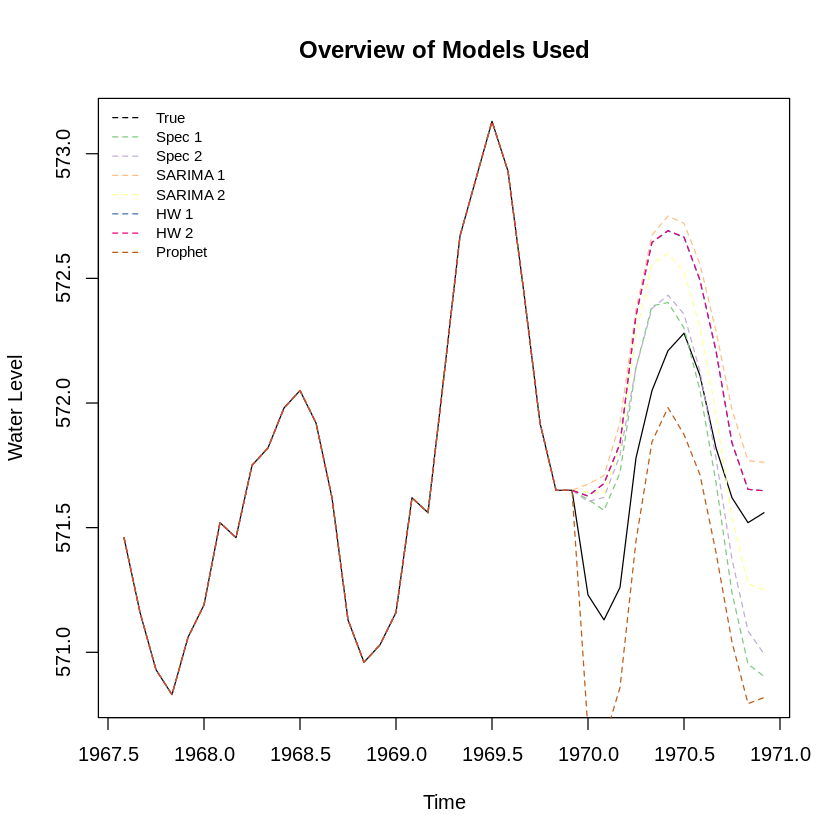

In [46]:
length(lkerie)
range<-560:600
plot(time(lkerie)[range],lkerie[range],ty="l",xlab="Time",ylab="Water Level",main="Overview of Models Used")
addplot(finalpred1,range,colors2[1])
addplot(finalpred2,range,colors2[2])
addplot(predarima1,range,colors2[3])
addplot(predarima2,range,colors2[4])
addplot(hw1pred,range,colors2[5])
addplot(hw2pred,range,colors2[6])
addplot(predproph,range,colors2[7])
lines(lkerie[range])

legend('topleft', c("True","Spec 1","Spec 2","SARIMA 1","SARIMA 2","HW 1","HW 2","Prophet"),col=c("black",colors2),
       lty="dashed", bty='n', cex=.75)


Finally, I produce graphs with confidence intervals for the most effective models of each type.



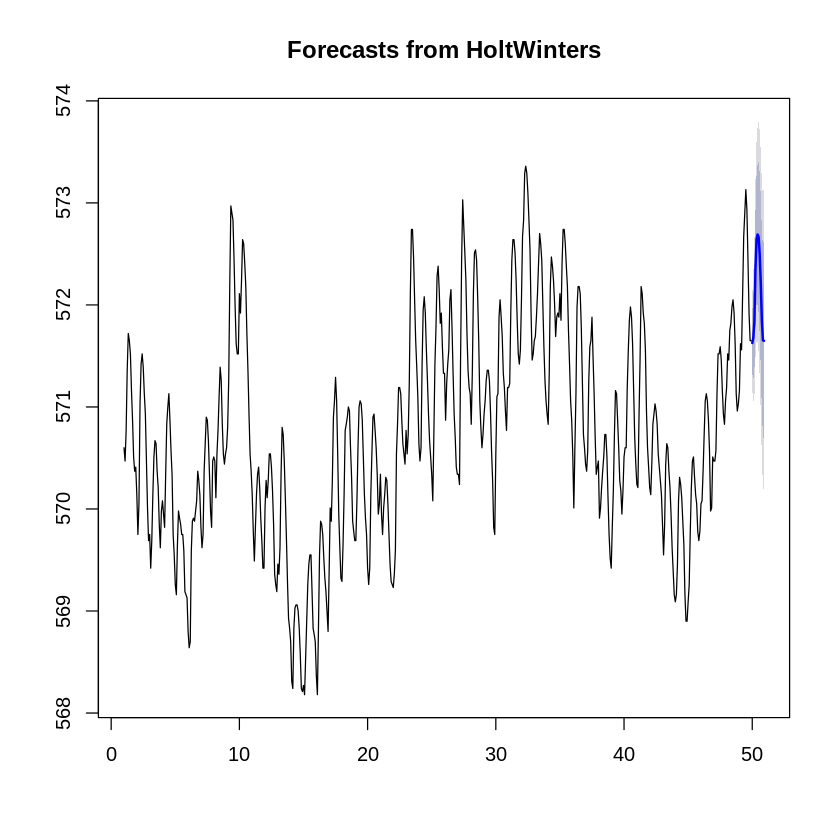

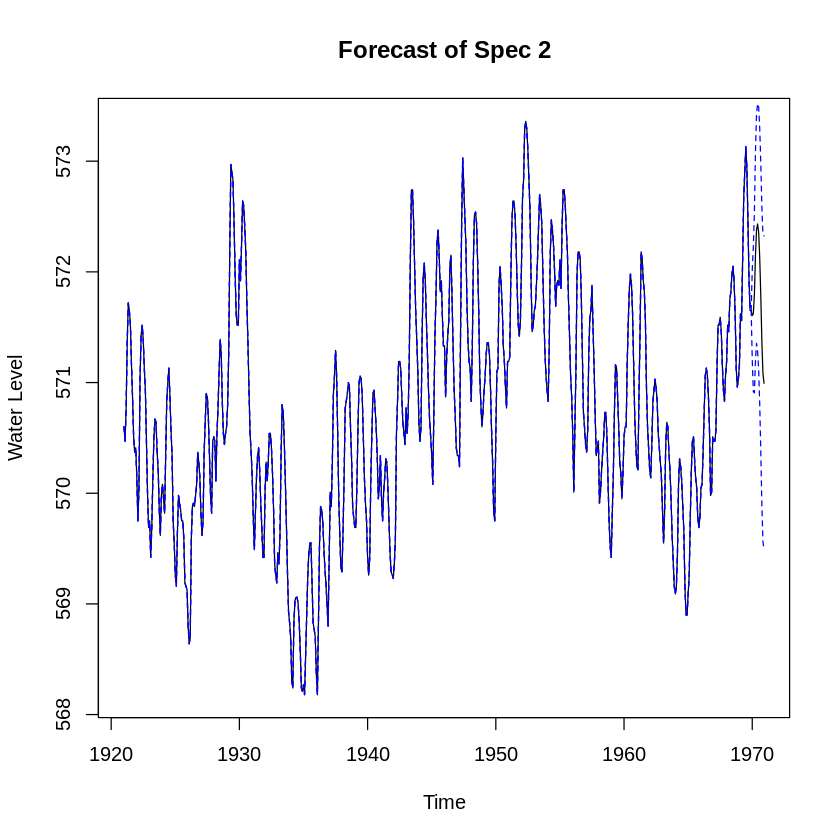

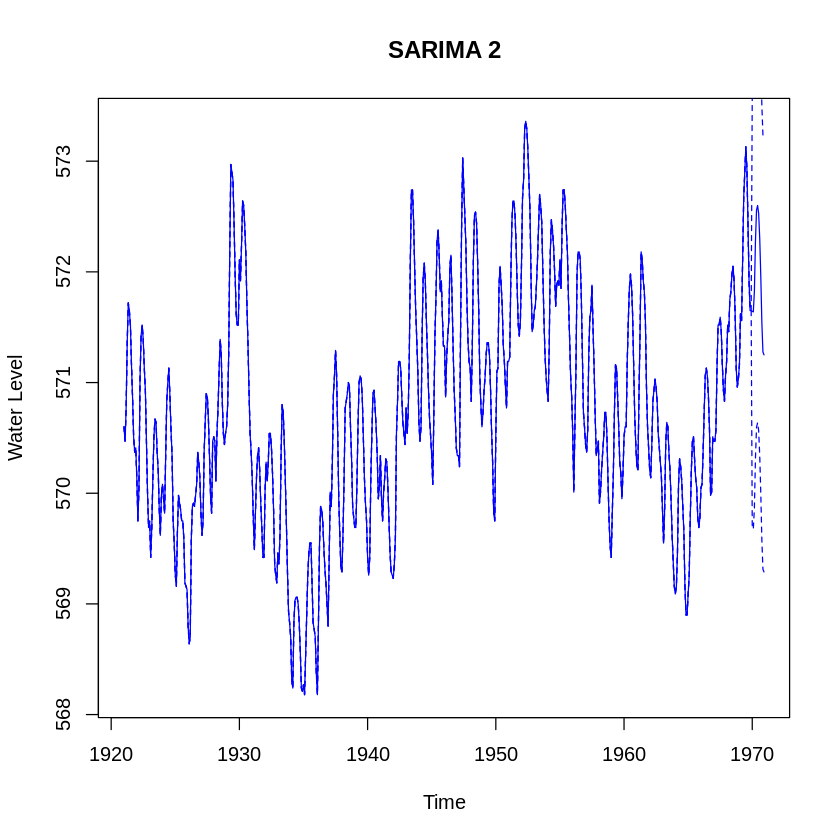

In [61]:
plot(forecast(hw1,12))

plot(x=time(lkerie),c(lkerietrain,finalpred2),ty="l",main="Forecast of Spec 2",xlab="Time",ylab="Water Level")
lines(x=c(time(lkerie)),c(lkerietrain,finalpred1+1.96*arimase1),lty="dashed",col="blue")
lines(x=c(time(lkerie)),c(lkerietrain,finalpred1-1.96*arimase1),lty="dashed",col="blue")
lines(lkerietrain,col="black")

plot(time(lkerie), c(lkerietrain,predarima2), ty='l', col="blue",main="SARIMA 2",xlab="Time",ylab="Water Level")
lines(x=c(time(lkerie)),c(lkerietrain,(predarima2+1.96*searima2)),col="blue",lty="dashed")
lines(x=c(time(lkerie)),c(lkerietrain,(predarima2-1.96*searima2)),col="blue",lty="dashed")
lines(lkerietrain)